## Imports

In [2]:
# Imports

import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import math
%matplotlib inline

import trading_module as tm
import datetime
from scipy.stats import linregress
from IPython.display import Image

pd.set_option("display.max_rows", None, "display.max_columns", None)

## Functions

### Closing

In [3]:
'''Function that provides Close_Up/Close_Dw depending on how it closed in regards to the open.

INPUTS:

 - df

OUTPUTS:

 - ['Closing'] ==> output: col with 2 vbles: Close_Dw & Close_Up.

'''
def Closing(df):
    df['Closing'] = df.apply(lambda x : 'C_Dw' if x['Open'] >= x['Close'] else 'C_Up', axis=1)

### Market Structure

In [4]:
'''Function that provides the Market Structure on the df adding the following cols outputs:

INPUTS:

 - df

OUTPUTS:

 - MS_H         ==> output: value of Market structure High for each data point
 - MS_L         ==> output: value of Market structure Low  for each data point
 - MS_Sit    ==> outputs: 'MS', 'Settling','Up_Break', 'Dw_Break'
'''

def Market_Structure(df,clean_sweep,x):
    
# Initiates 1st row;

    for i in range (0,10*x):
        
        df.loc[df.index[i],'MS_L'] = df.loc[df.index[i],'Low']   
        df.loc[df.index[i],'MS_H'] = df.loc[df.index[i],'High']
        df.loc[df.index[i],'MS_Sit'] = 'MS'
        df.loc[df.index[i],'MS_N'] = 0
 
    for i in range(10*x,len(df)):
        
        i = i + df.index[0]
    
    # From 'MS'/'Dw_break' => 'Up_break' situation
        if (df.loc[i-1,'MS_Sit'] not in ('Up_Break')) & (df.loc[i,'Close'] > df.loc[i-1,'MS_H'] + 0.0001*clean_sweep):
            
            df.loc[i,'MS_Sit'] = 'Up_Break'
            df.loc[i,'MS_H']   = df.loc[i,'High']
            df.loc[i,'MS_N']   = df.loc[i-1,'MS_N'] + 1

        # Id 1st Low swing before the break
            for j in range (0,1000):
                if (df.loc[(i-j),'Low'] >= df.loc[(i-j) -1 ,'Low']):
                    continue
                else:
                    if df.loc[(i-j),'Low'] < df.loc[i-j-x:i-j-1,'Low'].min():
                        df.loc[i,'MS_L'] = df.loc[(i-j),'Low']
                        break
                    else:
                        continue
        
    # From 'MS'/'Up_break' => 'Dw_break' situation
        elif (df.loc[i-1,'MS_Sit'] not in ('Dw_Break')) & (df.loc[i,'Close'] < df.loc[i-1,'MS_L']- 0.0001*clean_sweep):
            
            df.loc[i,'MS_Sit'] = 'Dw_Break'
            df.loc[i,'MS_L']   = df.loc[i,'Low']
            df.loc[i,'MS_N']   = df.loc[i-1,'MS_N'] + 1

        # Id 1st High swing before the break
            for j in range (0,1000):
                if (df.loc[(i-j),'High'] <= df.loc[(i-j) -1 ,'High']):
                    continue
                else:
                    if df.loc[(i-j),'High'] > df.loc[i-j-x:i-j-1,'High'].max():
                        df.loc[i,'MS_H'] = df.loc[(i-j),'High']
                        break
                    else:
                        continue

    # From Up_Break => Up_Break / Settling_Up       
        elif (df.loc[i-1,'MS_Sit'] in ('Up_Break','Settling_Up')) & (df.loc[i,'High'] > df.loc[i-1,'High']):
            
            df.loc[i,'MS_Sit'] = 'Settling_Up'
            df.loc[i,'MS_H']   = df.loc[i,'High']
            df.loc[i,'MS_L']   = df.loc[i-1,'MS_L']
            df.loc[i,'MS_N']   = df.loc[i-1,'MS_N']

    # From Dw_Break => Dw_Break / Settling_Dw situation           
        elif (df.loc[i-1,'MS_Sit'] in ('Dw_Break','Settling_Dw')) & (df.loc[i,'Low'] < df.loc[i-1,'Low']):
            
            df.loc[i,'MS_Sit'] = 'Settling_Dw'
            df.loc[i,'MS_H']   = df.loc[i-1,'MS_H']
            df.loc[i,'MS_L']   = df.loc[i,'Low']
            df.loc[i,'MS_N']   = df.loc[i-1,'MS_N']

    # From MS => MS situation             
        else:
            
            df.loc[i,'MS_Sit'] = 'MS'
            df.loc[i,'MS_H']   = df.loc[i-1,'MS_H']
            df.loc[i,'MS_L']   = df.loc[i-1,'MS_L']
            df.loc[i,'MS_N']   = df.loc[i-1,'MS_N']

### Trend

In [5]:
'''Function that calculates the trend based on the previous MS break:

INPUTS:

 - df

OUTPUTS:

 - Trend  ==> outputs: 'Up', 'Dw' (depending on the value of the previous Break) 

'''

def Trend(df):

    df.loc[df['MS_Sit'] == 'Dw_Break','Trend'] = 'Dw'
    df.loc[df['MS_Sit'] == 'Up_Break','Trend'] = 'Up'
    
    for i in range(1,len(df)):
        
        i = i + df.index[0]
        
        if df.loc[i,'MS_Sit'] not in ('Dw_Break','Up_Break'):
            df.loc[i,'Trend'] = df.loc[i-1,'Trend']
            
        df['Trend'] = df['Trend'].fillna('none')        

### N_Breaks

In [6]:
'''Function that calculates the number of previous breaks in the same direction:

INPUTS:

 - df

OUTPUTS:

 - N_Breaks ==> value of the the number of previous breaks in the same direction

'''

def N_Breaks(df):
    
    # Correction of ('Dw_Break','Up_Break')
    
    for i in range (1,len(df)):
        
        i = i + df.index[0]
        
        if (df.loc[i,'MS_Sit'] == 'Dw_Break') & (df.loc[i-1,'MS_Sit'] == 'Settling_Dw'):
            df.loc[i,'MS_Sit'] = 'Settling_Dw'
            
        elif (df.loc[i,'MS_Sit'] == 'Up_Break') & (df.loc[i-1,'MS_Sit'] == 'Settling_Up'):
            df.loc[i,'MS_Sit'] = 'Settling_Up'
        
        else:
            pass
            
    
    df['N_Breaks'] = 0
    #df.loc[0,'N_Breaks'] = 0
    
    for i in range (1,len(df)):
        
        i = i + df.index[0]
        
        if df.loc[i,'MS_Sit'] not in ('Dw_Break','Up_Break'):
            df.loc[i,'N_Breaks'] = df.loc[i-1,'N_Breaks']
        elif (df.loc[i,'MS_Sit'] == 'Up_Break'):
            if (df.loc[i-1,'Trend'] == 'Dw'):
                df.loc[i,'N_Breaks'] = 1
            else:
                df.loc[i,'N_Breaks'] = df.loc[i-1,'N_Breaks'] + 1
        elif (df.loc[i,'MS_Sit'] == 'Dw_Break'):
            if (df.loc[i-1,'Trend'] == 'Up'):
                df.loc[i,'N_Breaks'] = -1
            else:
                df.loc[i,'N_Breaks'] = df.loc[i-1,'N_Breaks'] - 1
                
    df['N_Breaks'] = df['N_Breaks'].abs()

### N_Periods_MS

In [7]:
'''Function that calculates the number of periods the price remains in MS:

INPUTS:

 - df

OUTPUTS:

 - N_periods_MS ==> value of the range within the same MS

'''

def MS_periods(df):

    df.loc[df.index[0],'MS_Pds'] = 0
    
    for i in range (1,len(df)):
        
        i = i + df.index[0]
        
        if (df.loc[i-1,'MS_Sit'] == 'MS') & (df.loc[i,'MS_Sit'] == 'MS'):
            df.loc[i,'MS_Pds'] = df.loc[i-1,'MS_Pds'] + 1
        
        elif (df.loc[i-1,'MS_Sit'] != 'MS') & (df.loc[i,'MS_Sit'] == 'MS'):
            df.loc[i,'MS_Pds'] = 1
        
        else:
            df.loc[i,'MS_Pds'] = 0
    
    # Converts column into integers
    df['MS_Pds'] = df['MS_Pds'].apply(np.int64)

### MS_Range

In [8]:
'''Function that calculates the number of pips between MS_High & MS_Low within MS:

INPUTS:

 - df

OUTPUTS:

 - MS_range ==> value of the range (MS_H - MS_L) within the same MS

'''

def MS_range(df):
    
    df['MS_range'] = 10000 * (df['MS_H'] - df['MS_L'])
    df['MS_retracement'] = df.apply(lambda x: 100 * (x['Close'] - x['MS_L']) /(x['MS_H'] - x['MS_L']) if x['Trend'] == 'Dw' else (100 * (x['MS_H'] - x['Close'])/(x['MS_H'] - x['MS_L'])), axis=1)
    df['MS_retracement'] = df['MS_retracement'].round(1)

### Merges D1- H4 - H1

In [9]:
def Merge_shift_df_4H_1D(df1,df2):
    
    '''Function that merges de 4H & 1D dataframes (df1 & df2)

    INPUTS:

     - df1    : df4H
     - df2    : df1D

    OUTPUTS:

     - New merged df

    '''

    df1.iloc[:, 0] = pd.to_datetime(df1.iloc[:, 0], dayfirst=True)
    df2.iloc[:, 0] = pd.to_datetime(df2.iloc[:, 0], dayfirst=True)
    
    df1['Date_del'] = df1.iloc[:, 0] + dt.timedelta(hours=4) 
    df2['Date_del'] = df2.iloc[:, 0] + dt.timedelta(days=1)

    df = pd.merge(df1, df2, how='left', on='Date_del')
    
    df1.drop(['Date_del'],axis=1,inplace=True)
    df2.drop(['Date_del'],axis=1,inplace=True)
    df.drop( ['Date_del'],axis=1,inplace=True)
    
    df = df.ffill(axis=0)
    
    return df

In [10]:
def Merge_shift_df_1H_4H(df1,df2):
    
    '''Function that merges de 15M & 4H dataframes (df1 & df2)

    INPUTS:

     - df1    : df1H
     - df2    : df4H or (df4H_1D)

    OUTPUTS:

     - New merged df

    '''
    
    df1.iloc[:, 0] = pd.to_datetime(df1.iloc[:, 0], dayfirst=True)
    df2.iloc[:, 0] = pd.to_datetime(df2.iloc[:, 0], dayfirst=True)
    
    df1['Date_del'] = df1.iloc[:, 0] + dt.timedelta(hours=1) 
    df2['Date_del'] = df2.iloc[:, 0] + dt.timedelta(hours=4)
   
    df = pd.merge(df1, df2, how='left', on='Date_del')
    
    df['Date_H4'] = df['Date_H4'].ffill(axis=0)
    
    df1.drop(['Date_del'],axis=1,inplace=True)
    df2.drop(['Date_del'],axis=1,inplace=True)
    df.drop(['Date_del'],axis=1,inplace=True)
    
    df = df.ffill(axis=0)
    
    return df

In [11]:
def Rename_df(df,suffix):
    
    '''Function that renames all columns adding the suffix at the end

    INPUTS:

     - df     : Dataframe
     - suffix : '1D', '4H' or '15M' to rename the columns

    OUTPUTS:

     - New df with renamed columns

    '''

    keys = df.columns
    values = keys + '_' + suffix
    dictionary = dict(zip(keys, values))
    
    df = df.rename(columns=dictionary)
    
    return df

### Plot

In [12]:
import matplotlib.pyplot as plt 
import pandas as pd
import matplotlib.dates as mpl_dates
import plotly.graph_objects as go
import datetime

def plot_MS(df, date, rng):
    
    p = df[df['Date'] == date].index[0]
    i = p
    j = p + rng
    
    dfp = df.loc[i:j,['Date', 'Open', 'High', 'Low', 'Close']]
    
    fig = go.Figure(data=[go.Candlestick(x=dfp['Date'],
                    open=dfp['Open'],
                    high=dfp['High'],
                    low=dfp['Low'],
                    close=dfp['Close'])])

    fig.update_layout(width=1000, height=1000,margin=dict(l=0, r=20, b=100, t=20, pad=4))
    
    for k in range(i,j):
        
        fig.add_shape(
                # Line Horizontal - ['MS_H']
                    type="line",
                    x0 = df.loc[k,'Date'],
                    y0 = df.loc[k,'MS_H'],
                    x1 = df.loc[k+1,'Date'],
                    y1 = df.loc[k,'MS_H'],
                    line=dict(
                        color="Green",
                        width=4,
                        dash="dashdot",
                    ))

        fig.add_shape(
                # Line Horizontal - ['MS_L']
                    type="line",
                    x0 = df.loc[k,'Date'],
                    y0 = df.loc[k,'MS_L'],
                    x1 = df.loc[k+1,'Date'],
                    y1 = df.loc[k,'MS_L'],
                    line=dict(
                        color="Blue",
                        width=4,
                        dash="dashdot",
                    ))
    
    print(df.loc[p,'Date'])
    fig.show()

In [13]:
import matplotlib.pyplot as plt 
import pandas as pd
import matplotlib.dates as mpl_dates
import plotly.graph_objects as go
import datetime

def plot_MS_all(df, date, rng):
    
    p = df[df['Date_H1'] == date].index[0]
    i = p - rng
    j = p + rng
    
    dfp = df.loc[i:j,['Date_H1', 'Open_H1', 'High_H1', 'Low_H1', 'Close_H1']]
    
    fig = go.Figure(data=[go.Candlestick(x=dfp['Date_H1'],
                    open=dfp['Open_H1'],
                    high=dfp['High_H1'],
                    low=dfp['Low_H1'],
                    close=dfp['Close_H1'])])

    fig.update_layout(width=1000, height=2000,margin=dict(l=0, r=20, b=100, t=20, pad=4))    
    
    for k in range(i,j):
        
        fig.add_shape(
                # Line Horizontal - ['MS_H_H1']
                    type="line",
                    x0 = df.loc[k,'Date_H1'],
                    y0 = df.loc[k,'MS_H_H1'],
                    x1 = df.loc[k+1,'Date_H1'],
                    y1 = df.loc[k,'MS_H_H1'],
                    line=dict(
                        color="Blue",
                        width=4,
                        dash="dashdot",
                    ))

        fig.add_shape(
                # Line Horizontal - ['MS_L_H1']
                    type="line",
                    x0 = df.loc[k,'Date_H1'],
                    y0 = df.loc[k,'MS_L_H1'],
                    x1 = df.loc[k+1,'Date_H1'],
                    y1 = df.loc[k,'MS_L_H1'],
                    line=dict(
                        color="Blue",
                        width=4,
                        dash="dashdot",
                    ))
        
        fig.add_shape(
                # Line Horizontal - ['MS_H_H4']
                    type="line",
                    x0 = df.loc[k,'Date_H1'],
                    y0 = df.loc[k,'MS_H_H4'],
                    x1 = df.loc[k+1,'Date_H1'],
                    y1 = df.loc[k,'MS_H_H4'],
                    line=dict(
                        color="Red",
                        width=4,
                        dash="dashdot",
                    ))

        fig.add_shape(
                # Line Horizontal - ['MS_L_H4']
                    type="line",
                    x0 = df.loc[k,'Date_H1'],
                    y0 = df.loc[k,'MS_L_H4'],
                    x1 = df.loc[k+1,'Date_H1'],
                    y1 = df.loc[k,'MS_L_H4'],
                    line=dict(
                        color="Red",
                        width=4,
                        dash="dashdot",
                    ))
        
        fig.add_shape(
                # Line Horizontal - ['MS_H_D1']
                    type="line",
                    x0 = df.loc[k,'Date_H1'],
                    y0 = df.loc[k,'MS_H_D1'],
                    x1 = df.loc[k+1,'Date_H1'],
                    y1 = df.loc[k,'MS_H_D1'],
                    line=dict(
                        color="Yellow",
                        width=4,
                        dash="dashdot",
                    ))

        fig.add_shape(
                # Line Horizontal - ['MS_L_D1']
                    type="line",
                    x0 = df.loc[k,'Date_H1'],
                    y0 = df.loc[k,'MS_L_D1'],
                    x1 = df.loc[k+1,'Date_H1'],
                    y1 = df.loc[k,'MS_L_D1'],
                    line=dict(
                        color="Yellow",
                        width=4,
                        dash="dashdot",
                    ))
    
    print(df.loc[p,'Date_H1'])
    fig.show()

### Price

In [15]:
def Price_H1(df,ratio):
    
    # Price
    df['Price_H1']       = df['Close_H1'].shift()
    df['B_Stop_Loss_H1'] = 10000 * (df['Price_H1'] - df['MS_L_H1'])
    df['B_Limit_H1']     = ratio * df['B_Stop_Loss_H1']
    df['S_Stop_Loss_H1'] = 10000 * (df['MS_H_H1'] - df['Price_H1'])
    df['S_Limit_H1']     = ratio * df['S_Stop_Loss_H1']
    
    df['Price_H4']       = df['Close_H4'].shift()
    df['B_Stop_Loss_H4'] = 10000 * (df['Price_H4'] - df['MS_L_H4'])
    df['B_Limit_H4']     = ratio * df['B_Stop_Loss_H4']
    df['S_Stop_Loss_H4'] = 10000 * (df['MS_H_H4'] - df['Price_H4'])
    df['S_Limit_H4']     = ratio * df['S_Stop_Loss_H4']

    #df['Price_H1'] = df['Close_H1'].shift()
    df['B_Stop_Loss_H1_H4'] = 10000 * (df['Price_H1'] - df['MS_L_H4'])
    df['B_Limit_H1_H4']     = ratio * df['B_Stop_Loss_H1_H4']
    df['S_Stop_Loss_H1_H4'] = 10000 * (df['MS_H_H4'] - df['Price_H1'])
    df['S_Limit_H1_H4']     = ratio * df['S_Stop_Loss_H1_H4']
    
# BUY
# Losing Index   
    for i in range(0,len(df)):
        if len(np.where((df['Low_H1'] <= df.loc[i,'Price_H1'] - (0.0001*(df.loc[i,'B_Stop_Loss_H1']))) & (df['Low_H1'].index > i))[0]) == 0:
            df.loc[i, 'B_Lose_Idx_H1'] = 1000000
            if i%5000 == 0:
                print(i)
        else:
            df.loc[i, 'B_Lose_Idx_H1'] = np.where((df['Low_H1'] <= df.loc[i,'Price_H1'] - (0.0001*(df.loc[i,'B_Stop_Loss_H1']))) & (df['Low_H1'].index > i))[0][0]
            if i%5000 == 0:
                print(i)
# BUY
# Winning Index
    for i in range(0,len(df)):
        if len(np.where((df['High_H1'] >= df.loc[i,'Price_H1'] + (0.0001*(df.loc[i,'B_Limit_H1']))) & (df['High_H1'].index > i))[0]) == 0:
            df.loc[i, 'B_Win_Idx_H1'] = 1000000
            if i%5000 == 0:
                print(i)
        else:
            df.loc[i, 'B_Win_Idx_H1'] = np.where((df['High_H1'] >= df.loc[i,'Price_H1'] + (0.0001*(df.loc[i,'B_Limit_H1']))) & (df['High_H1'].index > i))[0][0]
            if i%5000 == 0:
                print(i)
# SELL
# Losing Index
    for i in range(0,len(df)):
        if len(np.where((df['High_H1'] >= df.loc[i,'Price_H1'] + (0.0001*(df.loc[i,'S_Stop_Loss_H1']))) & (df['High_H1'].index > i))[0]) == 0:
            df.loc[i, 'S_Lose_Idx_H1'] = 1000000
            if i%5000 == 0:
                print(i)
        else:
            df.loc[i, 'S_Lose_Idx_H1'] = np.where((df['High_H1'] >= df.loc[i,'Price_H1'] + (0.0001*(df.loc[i,'S_Stop_Loss_H1']))) & (df['High_H1'].index > i))[0][0]
            if i%5000 == 0:
                print(i)
# SELL
# Winning Index
    for i in range(0,len(df)):
        if len(np.where((df['Low_H1'] <= df.loc[i,'Price_H1'] - (0.0001*(df.loc[i,'S_Limit_H1']))) & (df['Low_H1'].index > i))[0]) == 0:
            df.loc[i, 'S_Win_Idx_H1'] = 1000000
            if i%5000 == 0:
                print(i)
        else:
            df.loc[i, 'S_Win_Idx_H1'] = np.where((df['Low_H1'] <= df.loc[i,'Price_H1'] - (0.0001*(df.loc[i,'S_Limit_H1']))) & (df['Low_H1'].index > i))[0][0]
            if i%5000 == 0:
                print(i)
# Label
# 1 if B_Win Index < B_Lose Index
    df['Labelb_H1'] = df.apply(lambda x: 1 if x['B_Win_Idx_H1'] < x['B_Lose_Idx_H1'] else 0, axis=1)

# -1 if S_Win Index < S_Lose Index  
    df['Labels_H1'] = df.apply(lambda x: 1 if x['S_Win_Idx_H1'] < x['S_Lose_Idx_H1'] else 0, axis=1) 
    
    return df

In [16]:
def Price_H4(df,ratio):
    
    # Price
    df['Price_H1']       = df['Close_H1'].shift()
    df['B_Stop_Loss_H1'] = 10000 * (df['Price_H1'] - df['MS_L_H1'])
    df['B_Limit_H1']     = ratio * df['B_Stop_Loss_H1']
    df['S_Stop_Loss_H1'] = 10000 * (df['MS_H_H1'] - df['Price_H1'])
    df['S_Limit_H1']     = ratio * df['S_Stop_Loss_H1']
    
    df['Price_H4']       = df['Close_H4'].shift()
    df['B_Stop_Loss_H4'] = 10000 * (df['Price_H4'] - df['MS_L_H4'])
    df['B_Limit_H4']     = ratio * df['B_Stop_Loss_H4']
    df['S_Stop_Loss_H4'] = 10000 * (df['MS_H_H4'] - df['Price_H4'])
    df['S_Limit_H4']     = ratio * df['S_Stop_Loss_H4']

    #df['Price_H1'] = df['Close_H1'].shift()
    df['B_Stop_Loss_H1_H4'] = 10000 * (df['Price_H1'] - df['MS_L_H4'])
    df['B_Limit_H1_H4']     = ratio * df['B_Stop_Loss_H1_H4']
    df['S_Stop_Loss_H1_H4'] = 10000 * (df['MS_H_H4'] - df['Price_H1'])
    df['S_Limit_H1_H4']     = ratio * df['S_Stop_Loss_H1_H4']
    
# BUY
# Losing Index   
    for i in range(0,len(df)):
        if len(np.where((df['Low_H4'] <= df.loc[i,'Price_H4'] - (0.0001*(df.loc[i,'B_Stop_Loss_H4']))) & (df['Low_H4'].index > i))[0]) == 0:
            df.loc[i, 'B_Lose_Idx_H4'] = 1000000
            if i%5000 == 0:
                print(i)
        else:
            df.loc[i, 'B_Lose_Idx_H4'] = np.where((df['Low_H4'] <= df.loc[i,'Price_H4'] - (0.0001*(df.loc[i,'B_Stop_Loss_H4']))) & (df['Low_H4'].index > i))[0][0]
            if i%5000 == 0:
                print(i)
# BUY
# Winning Index
    for i in range(0,len(df)):
        if len(np.where((df['High_H4'] >= df.loc[i,'Price_H4'] + (0.0001*(df.loc[i,'B_Limit_H4']))) & (df['High_H4'].index > i))[0]) == 0:
            df.loc[i, 'B_Win_Idx_H4'] = 1000000
            if i%5000 == 0:
                print(i)
        else:
            df.loc[i, 'B_Win_Idx_H4'] = np.where((df['High_H4'] >= df.loc[i,'Price_H4'] + (0.0001*(df.loc[i,'B_Limit_H4']))) & (df['High_H1'].index > i))[0][0]
            if i%5000 == 0:
                print(i)
# SELL
# Losing Index
    for i in range(0,len(df)):
        if len(np.where((df['High_H4'] >= df.loc[i,'Price_H4'] + (0.0001*(df.loc[i,'S_Stop_Loss_H4']))) & (df['High_H4'].index > i))[0]) == 0:
            df.loc[i, 'S_Lose_Idx_H4'] = 1000000
            if i%5000 == 0:
                print(i)
        else:
            df.loc[i, 'S_Lose_Idx_H4'] = np.where((df['High_H4'] >= df.loc[i,'Price_H4'] + (0.0001*(df.loc[i,'S_Stop_Loss_H4']))) & (df['High_H1'].index > i))[0][0]
            if i%5000 == 0:
                print(i)
# SELL
# Winning Index
    for i in range(0,len(df)):
        if len(np.where((df['Low_H4'] <= df.loc[i,'Price_H4'] - (0.0001*(df.loc[i,'S_Limit_H4']))) & (df['Low_H4'].index > i))[0]) == 0:
            df.loc[i, 'S_Win_Idx_H4'] = 1000000
            if i%5000 == 0:
                print(i)
        else:
            df.loc[i, 'S_Win_Idx_H4'] = np.where((df['Low_H4'] <= df.loc[i,'Price_H4'] - (0.0001*(df.loc[i,'S_Limit_H4']))) & (df['Low_H1'].index > i))[0][0]
            if i%5000 == 0:
                print(i)

# Label                
# 1 if B_Win Index < B_Lose Index
    df['Labelb_H4'] = df.apply(lambda x: 1 if x['B_Win_Idx_H4'] < x['B_Lose_Idx_H4'] else 0, axis=1)

# -1 if S_Win Index < S_Lose Index  
    df['Labels_H4'] = df.apply(lambda x: 1 if x['S_Win_Idx_H4'] < x['S_Lose_Idx_H4'] else 0, axis=1)
    return df

In [17]:
def Price_H1_H4(df,ratio):
    
    # Price
    df['Price_H1']       = df['Close_H1'].shift()
    df['B_Stop_Loss_H1'] = 10000 * (df['Price_H1'] - df['MS_L_H1'])
    df['B_Limit_H1']     = ratio * df['B_Stop_Loss_H1']
    df['S_Stop_Loss_H1'] = 10000 * (df['MS_H_H1'] - df['Price_H1'])
    df['S_Limit_H1']     = ratio * df['S_Stop_Loss_H1']
    
    df['Price_H4']       = df['Close_H4'].shift()
    df['B_Stop_Loss_H4'] = 10000 * (df['Price_H4'] - df['MS_L_H4'])
    df['B_Limit_H4']     = ratio * df['B_Stop_Loss_H4']
    df['S_Stop_Loss_H4'] = 10000 * (df['MS_H_H4'] - df['Price_H4'])
    df['S_Limit_H4']     = ratio * df['S_Stop_Loss_H4']

    #df['Price_H1'] = df['Close_H1'].shift()
    df['B_Stop_Loss_H1_H4'] = 10000 * (df['Price_H1'] - df['MS_L_H4'])
    df['B_Limit_H1_H4']     = ratio * df['B_Stop_Loss_H1_H4']
    df['S_Stop_Loss_H1_H4'] = 10000 * (df['MS_H_H4'] - df['Price_H1'])
    df['S_Limit_H1_H4']     = ratio * df['S_Stop_Loss_H1_H4']
    
# BUY
# Losing Index   
    for i in range(0,len(df)):
        if len(np.where((df['Low_H1'] <= df.loc[i,'Price_H1'] - (0.0001*(df.loc[i,'B_Stop_Loss_H1_H4']))) & (df['Low_H1'].index > i))[0]) == 0:
            df.loc[i, 'B_Lose_Idx_H1_H4'] = 1000000
            if i%5000 == 0:
                print(i)
        else:
            df.loc[i, 'B_Lose_Idx_H1_H4'] = np.where((df['Low_H1'] <= df.loc[i,'Price_H1'] - (0.0001*(df.loc[i,'B_Stop_Loss_H1_H4']))) & (df['Low_H1'].index > i))[0][0]
            if i%5000 == 0:
                print(i)
# BUY
# Winning Index
    for i in range(0,len(df)):
        if len(np.where((df['High_H1'] >= df.loc[i,'Price_H1'] + (0.0001*(df.loc[i,'B_Limit_H1_H4']))) & (df['High_H1'].index > i))[0]) == 0:
            df.loc[i, 'B_Win_Idx_H1_H4'] = 1000000
            if i%5000 == 0:
                print(i)
        else:
            df.loc[i, 'B_Win_Idx_H1_H4'] = np.where((df['High_H1'] >= df.loc[i,'Price_H1'] + (0.0001*(df.loc[i,'B_Limit_H1_H4']))) & (df['High_H1'].index > i))[0][0]
            if i%5000 == 0:
                print(i)
# SELL
# Losing Index
    for i in range(0,len(df)):
        if len(np.where((df['High_H1'] >= df.loc[i,'Price_H1'] + (0.0001*(df.loc[i,'S_Stop_Loss_H1_H4']))) & (df['High_H1'].index > i))[0]) == 0:
            df.loc[i, 'S_Lose_Idx_H1_H4'] = 1000000
            if i%5000 == 0:
                print(i)
        else:
            df.loc[i, 'S_Lose_Idx_H1_H4'] = np.where((df['High_H1'] >= df.loc[i,'Price_H1'] + (0.0001*(df.loc[i,'S_Stop_Loss_H1_H4']))) & (df['High_H1'].index > i))[0][0]
            if i%5000 == 0:
                print(i)
# SELL
# Winning Index
    for i in range(0,len(df)):
        if len(np.where((df['Low_H1'] <= df.loc[i,'Price_H1'] - (0.0001*(df.loc[i,'S_Limit_H1_H4']))) & (df['Low_H1'].index > i))[0]) == 0:
            df.loc[i, 'S_Win_Idx_H1_H4'] = 1000000
            if i%5000 == 0:
                print(i)
        else:
            df.loc[i, 'S_Win_Idx_H1_H4'] = np.where((df['Low_H1'] <= df.loc[i,'Price_H1'] - (0.0001*(df.loc[i,'S_Limit_H1_H4']))) & (df['Low_H1'].index > i))[0][0]
            if i%5000 == 0:
                print(i)

# Label
# 1 if B_Win Index < B_Lose Index
    df['Labelb_H1_H4'] = df.apply(lambda x: 1 if x['B_Win_Idx_H1_H4'] < x['B_Lose_Idx_H1_H4'] else 0, axis=1)

# -1 if S_Win Index < S_Lose Index  
    df['Labels_H1_H4'] = df.apply(lambda x: 1 if x['S_Win_Idx_H1_H4'] < x['S_Lose_Idx_H1_H4'] else 0, axis=1)
    return df

In [21]:
df = Price_H1(df,3)

0
5000
10000
15000
20000
25000
30000
35000
0
5000
10000
15000
20000
25000
30000
35000
0
5000
10000
15000
20000
25000
30000
35000
0
5000
10000
15000
20000
25000
30000
35000


In [22]:
df = Price_H4(df,3)

0
5000
10000
15000
20000
25000
30000
35000
0
5000
10000
15000
20000
25000
30000
35000
0
5000
10000
15000
20000
25000
30000
35000
0
5000
10000
15000
20000
25000
30000
35000


In [23]:
df = Price_H1_H4(df,3)

0
5000
10000
15000
20000
25000
30000
35000
0
5000
10000
15000
20000
25000
30000
35000
0
5000
10000
15000
20000
25000
30000
35000
0
5000
10000
15000
20000
25000
30000
35000


### Label

In [245]:
df.loc[19000:20000,['Low_H1','MS_L_H1','Price_H1','B_Stop_Loss_H1','B_Lose_Idx_H1']]

Low_H1  MS_L_H1  Price_H1  B_Stop_Loss_H1  B_Lose_Idx_H1
19000  1.22262  1.21650   1.22433            78.3        19712.0
19001  1.22365  1.21650   1.22386            73.6        19712.0
19002  1.22339  1.21650   1.22377            72.7        19712.0
19003  1.22317  1.21650   1.22405            75.5        19712.0
19004  1.22321  1.21650   1.22340            69.0        19712.0
19005  1.22322  1.21650   1.22367            71.7        19712.0
19006  1.22400  1.21650   1.22433            78.3        19712.0
19007  1.22434  1.21650   1.22445            79.5        19712.0
19008  1.22593  1.21650   1.22668           101.8        19712.0
19009  1.22530  1.21650   1.22623            97.3        19712.0
19010  1.22573  1.21650   1.22606            95.6        19712.0
19011  1.22513  1.21650   1.22590            94.0        19712.0
19012  1.22620  1.21650   1.22720           107.0        19712.0
19013  1.22650  1.21650   1.22830           118.0        19712.0
19014  1.22665  1.21650   1.22817           116.7        19712.0
19015  1.22559  1.21650   1.22740           109.0        19712.0
19016  1.22531  1.21650   1.22733           108.3        19712.0
19017  1.22393  1.21650   1.22568            91.8        19712.0
19018  1.22305  1.21650   1.22433            78.3        19712.0
19019  1.22184  1.21650   1.22506            85.6        19712.0
19020  1.22206  1.21650   1.22209            55.9        19712.0
19021  1.22312  1.21650   1.22373            72.3        19712.0
19022  1.22191  1.21650   1.22325            67.5        19712.0
19023  1.22315  1.21650   1.22325            67.5        19712.0
19024  1.22202  1.21650   1.22330            68.0        19712.0
19025  1.22145  1.21650   1.22209            55.9        19712.0
19026  1.22552  1.21650   1.22145            49.5        19712.0
19027  1.22338  1.21650   1.22590            94.0        19712.0
19028  1.22413  1.21650   1.22560            91.0        19712.0
19029  1.22251  1.21650   1.22441            79.1        19712.0
19030  1.22264  1.21650   1.22285            63.5        19712.0
19031  1.22247  1.21650   1.22366            71.6        19712.0
19032  1.22162  1.21650   1.22288            63.8        19712.0
19033  1.22172  1.21650   1.22238            58.8        19712.0
19034  1.22138  1.21650   1.22313            66.3        19712.0
19035  1.22156  1.21650   1.22160            51.0        19712.0
19036  1.22350  1.21650   1.22371            72.1        19712.0
19037  1.22416  1.21650   1.22417            76.7        19712.0
19038  1.22475  1.21650   1.22495            84.5        19712.0
19039  1.22513  1.21650   1.22620            97.0        19712.0
19040  1.22390  1.21650   1.22550            90.0        19712.0
19041  1.22335  1.21650   1.22412            76.2        19712.0
19042  1.22383  1.21650   1.22493            84.3        19712.0
19043  1.22383  1.21650   1.22400            75.0        19712.0
19044  1.22281  1.21650   1.22537            88.7        19712.0
19045  1.22240  1.21650   1.22282            63.2        19712.0
19046  1.22392  1.21650   1.22434            78.4        19712.0
19047  1.22474  1.21650   1.22493            84.3        19712.0
19048  1.22543  1.21650   1.22583            93.3        19712.0
19049  1.22567  1.21650   1.22584            93.4        19712.0
19050  1.22573  1.21650   1.22614            96.4        19712.0
19051  1.22550  1.21650   1.22600            95.0        19712.0
19052  1.22560  1.21650   1.22562            91.2        19712.0
19053  1.22626  1.21650   1.22672           102.2        19712.0
19054  1.22508  1.21650   1.22662           101.2        19712.0
19055  1.22546  1.21650   1.22614            96.4        19712.0
19056  1.22550  1.21650   1.22575            92.5        19712.0
19057  1.22516  1.21650   1.22595            94.5        19712.0
19058  1.22439  1.21650   1.22578            92.8        19712.0
19059  1.22382  1.21650   1.22478            82.8        19712.0
19060  1.22230  1.21650   1.22512          

## Data Preparation
### Read Files and apply functions

In [19]:
df_H1 = pd.read_excel('../0. Data/EURUSD_H1_5y.xlsx')
Closing(df_H1) 
Market_Structure(df_H1, 1,3)
Trend(df_H1)
N_Breaks(df_H1)
MS_periods(df_H1)
MS_range(df_H1)
df_H1r = Rename_df(df_H1,'H1')

df_H4 = pd.read_excel('../0. Data/EURUSD_H4_5y.xlsx')
Closing(df_H4) 
Market_Structure(df_H4, 4,3)
Trend(df_H4)
N_Breaks(df_H4)
MS_periods(df_H4)
MS_range(df_H4)
df_H4r = Rename_df(df_H4,'H4')

df_D1 = pd.read_excel('../0. Data/EURUSD_D1_5y.xlsx')
Closing(df_D1) 
Market_Structure(df_D1, 16,3)
Trend(df_D1)
N_Breaks(df_D1)
MS_periods(df_D1)
MS_range(df_D1)
df_D1r = Rename_df(df_D1,'D1')

df4H_1D = Merge_shift_df_4H_1D(df_H4r,df_D1r)
df = Merge_shift_df_1H_4H(df_H1r,df4H_1D)

#### Merge dataframes - df

In [20]:
df4H_1D = Merge_shift_df_4H_1D(df_H4r,df_D1r)
df = Merge_shift_df_1H_4H(df_H1r,df4H_1D)

In [189]:
df['Date_H1'] = df['Date_H1'].apply(lambda x: dt.datetime.strftime(x, '%Y-%m-%d %H:%M'))
df['Date_H4'] = df['Date_H4'].apply(lambda x: dt.datetime.strftime(x, '%Y-%m-%d %H:%M'))
df['Date_D1'] = df['Date_D1'].apply(lambda x: dt.datetime.strftime(x, '%Y-%m-%d %H:%M'))

In [291]:
df.describe()

Open_H1       High_H1        Low_H1      Close_H1       MS_L_H1  \
count  35824.000000  35824.000000  35824.000000  35824.000000  35824.000000   
mean       1.128764      1.129563      1.127991      1.128764      1.122841   
std        0.042333      0.042317      0.042337      0.042331      0.043419   
min        1.035580      1.037020      1.034030      1.035620      1.035230   
25%        1.100950      1.101660      1.100250      1.100950      1.091160   
50%        1.122900      1.123660      1.122125      1.122905      1.117640   
75%        1.154855      1.155675      1.153950      1.154895      1.149600   
max        1.254880      1.255530      1.254320      1.254880      1.245710   

            MS_H_H1       MS_N_H1   N_Breaks_H1     MS_Pds_H1   MS_range_H1  \
count  35824.000000  35824.000000  35824.000000  35824.000000  35824.000000   
mean       1.135005    980.398699      3.149397     79.045835    121.635641   
std        0.041778    613.101302      2.527875    271.884253    117.407135   
min        1.041780      0.000000      0.000000      0.000000      5.900000   
25%        1.105560    485.000000      1.000000      4.000000     58.400000   
50%        1.132150    896.000000      2.000000     13.000000     86.300000   
75%        1.159280   1532.000000      4.000000     34.000000    125.400000   
max        1.255530   2102.000000     20.000000   2036.000000    516.200000   

       MS_retracement_H1       Open_H4       High_H4        Low_H4  \
count       35824.000000  35823.000000  35823.000000  35823.000000   
mean           36.826708      1.128755      1.130408      1.127165   
std            24.617873      0.042334      0.042307      0.042346   
min            -4.700000      1.037670      1.038920      1.034030   
25%            16.300000      1.101045      1.102320      1.099400   
50%            32.800000      1.122920      1.124460      1.121390   
75%            54.400000      1.154760      1.156750      1.152930   
max           105.700000      1.253920      1.255530      1.252650   

           Close_H4      MS_L_H4       MS_H_H4       MS_N_H4   N_Breaks_H4  \
count  35823.000000  35823.00000  35823.000000  35823.000000  35823.000000   
mean       1.128764      1.11873      1.140136    268.071853      2.964827   
std        0.042329      0.04278      0.042692    165.208152      2.382940   
min        1.037660      1.03665      1.055630      0.000000      0.000000   
25%        1.101050      1.09116      1.109070    131.000000      1.000000   
50%        1.122920      1.11146      1.137980    266.000000      2.000000   
75%        1.154780      1.14645      1.171390    422.000000      4.000000   
max        1.253920      1.23070      1.253730    578.000000     13.000000   

          MS_Pds_H4   MS_range_H4  MS_retracement_H4       Open_D1  \
count  35823.000000  35823.000000       35823.000000  35823.000000   
mean      39.613851    214.067577          38.452812      1.128668   
std       77.510473    152.298137          26.072812      0.042382   
min        0.000000     17.600000          -8.400000      1.039070   
25%        3.000000    106.600000          16.000000      1.100730   
50%       11.000000    164.000000          34.100000      1.122350   
75%       34.000000    275.100000          58.600000      1.154830   
max      526.000000    696.100000         108.400000      1.246820   

            High_D1        Low_D1      Close_D1       MS_L_D1       MS_H_D1  \
count  35823.000000  35823.000000  35823.000000  35823.000000  35823.000000   
mean       1.132393      1.125177      1.128785      1.108034      1.149508   
std        0.042292      0.042398      0.042311      0.045554      0.040495   
min        1.041780      1.034030      1.039060      1.036650      1.065790   
25%        1.103750      1.097000      1.101130      1.063570      1.124970   
50%        1.126200      1.119370      1.122420      1.101950      1.145000   
75%        1.158450      1.150820      1.155030      1.130920      1.1

#### First stage Strategy

Analyse the following Vables:
 - Trend_X == 'Up'/Dw
 - MS_retracement_X within (61.8%, 78.6%) of the MS_1D 23.6%, 38.2%, 50.0%, 61.8%, and 78.6%
 - N_Breaks_X between (x and y)
 - MS_range_X between (x and y)
 - X_Stop_Loss_X between (x and y), being the avgs 60 and 100 for H1 and H4 respectively
 
 
 ***Try all labels

#### Labelb_H1

In [ ]:
import random

Fib_list = [-10000, 0, 23.6, 38.2, 50, 61.8, 78.6, 90, 99, 10000]

for i in range(0,100000):

    a = random.randint(0, 1)
    a = 'Up' if a == 1 else 'Dw'
    
    b = random.randint(0, 1)
    b = 'Up' if b == 1 else 'Dw'
    
    c = random.randint(0, 1)
    c = 'Up' if c == 1 else 'Dw'

    r1 = random.choice(Fib_list)
    r2 = random.choice([i for i in Fib_list if i >= r1])

    s1 = random.choice(Fib_list)
    s2 = random.choice([i for i in Fib_list if i >= s1])
    
    t1 = random.choice(Fib_list)
    t2 = random.choice([i for i in Fib_list if i >= t1])

    u1 = random.randint(0,440)
    u2 = random.randint(u1,440)

    v1 = random.randint(0,440)
    v2 = random.randint(v1,440)

    w1 = random.randint(0,440)
    w2 = random.randint(w1,440)
    
    k1 = random.randint(0,10)
    k2 = random.randint(k1,10)
    
    #a = 'Up'
    #b = 'Dw'
    #r1 = 23.6
    #r2 = 50
    #k1 = 0
    #k2 = 3
    
    if (i % 1000) == 0: print('-->',i) 

    try:    
        x = df[(df['MS_retracement_H1'].between(-1000000, 1000000)) & 
           (df['Trend_D1'] == a) & 
           (df['Trend_H4'] == b) & 
           #(df['Trend_H1'] == c) & 
           (df['MS_retracement_D1'].between(r1, r2)) & # (23.6, 50) --> 1901 - 0.4003
           (df['MS_retracement_H4'].between(s1, s2)) & 
           (df['MS_retracement_H1'].between(t1, t2)) & 
           #(df['N_Breaks_D1'].between(k1, k2)) & # None
           #(df['N_Breaks_H4'].between(k1, k2)) & # None
           #(df['N_Breaks_H1'].between(0, 3)) & # (0, 3) --> 1464.0 - 0.4637
           #(df['MS_range_D1'].between(70, 78.6)) & 
           #(df['MS_range_H4'].between(70, 78.6)) & 
           (df['MS_range_H1'].between(0, 125)) & 
           #(df['B_Stop_Loss_H4'].between(u1, u2)) & 
           #(df['B_Stop_Loss_H1'].between(v1, v2)) & 
           #(df['B_Stop_Loss_H1_H4'].between(w1, w2)) &
           (df['MS_retracement_H1'].between(-1000000, 1000000))][['Labelb_H1']]

        y = x.index.to_list()
        z = remove_index(y,50)
        x = x.loc[z,:].describe()[:2]

        if (x[1] > 0.2) & (x[0] > 20):
            print(x[0],x[1],a,b,c,r1,r2,s1,s2,t1,t2,u1,u2,v1,v2,w1,w2,k1,k2)
    except:
        pass
# Best ['Trend_D1'] == 'Up', ['Trend_H4'] == 'Dw', ['MS_retracement_D1'].between(23.6, 50) --> 1901 - 0.4003
# + ['N_Breaks_H1'].between(0, 3) --> 1464.0 - 0.4637

In [84]:
x = df[(df['MS_retracement_H1'].between(-1000000, 1000000)) & 
   (df['Trend_D1'] == a) & 
   (df['Trend_H4'] == b) & 
   #(df['Trend_H1'] == c) & 
   #(df['MS_retracement_D1'].between(r1, r2)) & # (23.6, 50) --> 1901 - 0.4003
   #(df['MS_retracement_H4'].between(s1, s2)) & 
   #(df['MS_retracement_H1'].between(t1, t2)) & 
   #(df['N_Breaks_D1'].between(k1, k2)) & # None
   #(df['N_Breaks_H4'].between(k1, k2)) & # None
   #(df['N_Breaks_H1'].between(0, 3)) & # (0, 3) --> 1464.0 - 0.4637
   #(df['MS_range_D1'].between(70, 78.6)) & 
   #(df['MS_range_H4'].between(70, 78.6)) & 
   (df['MS_range_H1'].between(0, 125)) & 
   #(df['B_Stop_Loss_H4'].between(u1, u2)) & 
   #(df['B_Stop_Loss_H1'].between(v1, v2)) & 
   #(df['B_Stop_Loss_H1_H4'].between(w1, w2)) &
   (df['MS_retracement_H1'].between(-1000000, 1000000))][['Labelb_H1']]

In [ ]:
len(x)

In [86]:
y = x.index.to_list()
len(y)

7237

In [87]:
y

[984,
 985,
 986,
 987,
 988,
 989,
 990,
 991,
 992,
 993,
 994,
 995,
 996,
 997,
 998,
 999,
 1000,
 1001,
 1002,
 1003,
 1004,
 1005,
 1006,
 1007,
 1008,
 1009,
 1010,
 1011,
 1012,
 1013,
 1014,
 1015,
 1016,
 1017,
 1018,
 1019,
 1020,
 1021,
 1022,
 1023,
 1024,
 1025,
 1026,
 1027,
 1028,
 1029,
 1030,
 1031,
 1032,
 1033,
 1034,
 1035,
 1036,
 1037,
 1038,
 1039,
 1040,
 1041,
 1042,
 1043,
 1044,
 1045,
 1046,
 1047,
 1048,
 1049,
 1050,
 1051,
 1052,
 1053,
 1054,
 1055,
 1056,
 1057,
 1058,
 1059,
 1060,
 1061,
 1062,
 1063,
 1064,
 1065,
 1066,
 1067,
 1068,
 1069,
 1070,
 1071,
 1072,
 1073,
 1074,
 1091,
 1092,
 1093,
 1094,
 1095,
 1134,
 1135,
 1136,
 1137,
 1138,
 1139,
 1140,
 1141,
 1142,
 1143,
 1144,
 1145,
 1146,
 1147,
 1148,
 1149,
 1150,
 1151,
 1163,
 1164,
 1264,
 1265,
 1266,
 1267,
 1268,
 1269,
 1270,
 1271,
 1272,
 1273,
 1274,
 1275,
 1276,
 1277,
 1278,
 1279,
 1280,
 1281,
 1282,
 1283,
 1284,
 1285,
 1286,
 1287,
 1288,
 1289,
 1290,
 1291,
 1292,
 

In [88]:
z = remove_index(y,50)
len(z)

47

In [89]:
z

[984,
 1264,
 1714,
 2360,
 2692,
 3338,
 3594,
 3668,
 5248,
 5445,
 8676,
 11245,
 11626,
 12263,
 12499,
 12649,
 13210,
 13362,
 13478,
 17615,
 20684,
 21581,
 22720,
 23481,
 23680,
 23892,
 24039,
 24655,
 24841,
 24942,
 25614,
 25946,
 26138,
 26299,
 26759,
 27741,
 28397,
 29069,
 29521,
 31551,
 31735,
 32595,
 32695,
 33288,
 33576,
 34014,
 35703]

In [90]:
x

Labelb_H1
984            0
985            0
986            1
987            1
988            1
989            1
990            1
991            1
992            0
993            1
994            1
995            0
996            0
997            0
998            0
999            0
1000           0
1001           0
1002           0
1003           0
1004           0
1005           0
1006           0
1007           0
1008           0
1009           0
1010           0
1011           0
1012           0
1013           0
1014           0
1015           0
1016           0
1017           0
1018           0
1019           0
1020           0
1021           0
1022           1
1023           1
1024           1
1025           0
1026           0
1027           0
1028           0
1029           0
1030           0
1031           0
1032           0
1033           0
1034           0
1035           0
1036           0
1037           0
1038           0
1039           0
1040           0
1041           0
1042           0
1043           0
1044           0
1045           0
1046           0
1047           0
1048           0
1049           0
1050           0
1051           0
1052           0
1053           0
1054           0
1055           0
1056           0
1057           0
1058           0
1059           0
1060           0
1061           0
1062           0
1063           0
1064           0
1065           1
1066           0
1067           1
1068           1
1069           0
1070           0
1071           0
1072           0
1073           0
1074           0
1091           0
1092           0
1093           0
1094           0
1095           0
1134           0
1135           0
1136           0
1137           0
1138           0
1139           0
1140           0
1141           0
1142           0
1143           1
1144           0
1145           0
1146           0
1147           0
1148           0
1149           0
1150           0
1151           0
1163           0
1164           0
1264           1
1265           1
1266           1
1267           1
1268           1
1269           1
1270           1
1271           1
1272           1
1273           1
1274           1
1275           1
1276           1
1277           1
1278           1
1279           1
1280           1
1281           1
1282           1
1283           1
1284           1
1285           1
1286           1
1287           1
1288           1
1289           1
1290           1
1291           1
1292           1
1714           0
1715           0
1716           0
1717           0
1718           1
1719           1
1720           1
1721           1
1722           1
1723           1
1724           1
1725           1
1726           1
1727           1
1728           1
1729           1
1730           1
1731           1
1732           1
1733           1
1734           1
1735           1
1736           1
1737           1
1738           1
1739           1
1740           1
1741           1
1742           1
1743           1
2360           0
2361           0
2362           1
2363           0
2364           0
2365           0
2366           1
2367           0
2368           0
2369           0
2370           0
2371           1
2372           1
2373           0
2374           0
2375           0
2376           1
2377           1
2378           1
2379           0
2380           0
2381           0
2382           0
2383           0
2384           0
2385           0
2386           0
2387           0
2388           0
2389           0
2390           0
2391           0
2392           0
2393           0
2394           0
2395           0
2396           0
2397           0
2398           0
2399           0
2400           1
2401           1
2402           1
2403           1
2404           0
2405           0
2406           0
2407           0
2408           0
2409           0
2410           0
2411           0
2412           0
2413           0
2414           0
2451           0
2452           0
2453           0
2454           0
2455        

In [95]:
xx = x.loc[z,:].reset_index()

In [98]:
xx.describe()[:2]

index  Labelb_H1
count     47.000000  47.000000
mean   19193.319149   0.191489

In [30]:
l = [1,3,5,7,9]
df.loc[l]

Date_H1  Open_H1  High_H1   Low_H1  Close_H1 Closing_H1  \
1 2015-01-01 23:00:00  1.21015  1.21020  1.20783   1.20869       C_Dw   
3 2015-01-02 01:00:00  1.20675  1.20723  1.20519   1.20670       C_Dw   
5 2015-01-02 03:00:00  1.20586  1.20627  1.20552   1.20574       C_Dw   
7 2015-01-02 05:00:00  1.20529  1.20555  1.20461   1.20517       C_Dw   
9 2015-01-02 07:00:00  1.20545  1.20582  1.20349   1.20561       C_Up   

   MS_L_H1  MS_H_H1 MS_Sit_H1  MS_N_H1 Trend_H1  N_Breaks_H1  MS_Pds_H1  \
1  1.20783  1.21020        MS      0.0     none            0          1   
3  1.20519  1.20723        MS      0.0     none            0          3   
5  1.20552  1.20627        MS      0.0     none            0          5   
7  1.20461  1.20555        MS      0.0     none            0          7   
9  1.20349  1.20582        MS      0.0     none            0          9   

   MS_range_H1  MS_retracement_H1             Date_H4  Open_H4  High_H4  \
1         23.7               63.7 2015-01-01 20:00:00  1.21038  1.21073   
3         20.4               26.0 2015-01-01 20:00:00  1.21038  1.21073   
5          7.5               70.7 2015-01-02 00:00:00  1.20871  1.20890   
7          9.4               40.4 2015-01-02 00:00:00  1.20871  1.20890   
9         23.3                9.0 2015-01-02 04:00:00  1.20574  1.20597   

    Low_H4  Close_H4 Closing_H4  MS_L_H4  MS_H_H4 MS_Sit_H4  MS_N_H4 Trend_H4  \
1  1.20783   1.20869       C_Dw  1.20783  1.21073        MS      0.0     none   
3  1.20783   1.20869       C_Dw  1.20783  1.21073        MS      0.0     none   
5  1.20476   1.20574       C_Dw  1.20476  1.20890        MS      0.0     none   
7  1.20476   1.20574       C_Dw  1.20476  1.20890        MS      0.0     none   
9  1.20349   1.20561       C_Dw  1.20349  1.20597        MS      0.0     none   

   N_Breaks_H4  MS_Pds_H4  MS_range_H4  MS_retracement_H4    Date_D1  Open_D1  \
1          0.0        0.0         29.0               70.3 2015-01-01  1.21038   
3          0.0        0.0         29.0               70.3 2015-01-01  1.21038   
5          0.0        1.0         41.4               76.3 2015-01-01  1.21038   
7          0.0        1.0         41.4               76.3 2015-01-01  1.21038   
9          0.0        2.0         24.8               14.5 2015-01-01  1.21038   

   High_D1   Low_D1  Close_D1 Closing_D1  MS_L_D1  MS_H_D1 MS_Sit_D1  MS_N_D1  \
1  1.21073  1.20783   1.20869       C_Dw  1.20783  1.21073        MS      0.0   
3  1.21073  1.20783   1.20869       C_Dw  1.20783  1.21073        MS      0.0   
5  1.21073  1.20783   1.20869       C_Dw  1.20783  1.21073        MS      0.0   
7  1.21073  1.20783   1.20869       C_Dw  1.20783  1.21073        MS      0.0   
9  1.21073  1.20783   1.20869       C_Dw  1.20783  1.21073        MS      0.0   

  Trend_D1  N_Breaks_D1  MS_Pds_D1  MS_range_D1  MS_retracement_D1  Price_H1  \
1     none          0.0        0.0         29.0               70.3   1.21014   
3     none          0.0        0.0         29.0               70.3   1.20674   
5     none          0.0        0.0         29.0               70.3   1.20588   
7     none          0.0        0.0         29.0               70.3   1.20529   
9     none          0.0        0.0         29.0               70.3   1.20546   

   B_Stop_Loss_H1  B_Limit_H1  S_Stop_Loss_H1  S_Limit_H1  Price_H4  \
1            23.1        69.3             0.6         1.8       NaN   
3            15.5        46.5             4.9        14.7   1.20869   
5             3.6        10.8             3.9        11.7   1.20869   
7             6.8        20.4             2.6         7.8   1.20574   
9            19.7        59.1             3.6        10.8   1.20574   

   B_Stop_Loss_H4  B_Limit_H4  S_Stop_Loss_H4  S_Limit_H4  B_Stop_Loss_H1_H4  \
1             NaN         NaN             NaN         NaN               23.1   
3             8.6        25.8            20.4        61.2              -10.9   
5            39.3       117.9             2.1         6.3       

#### Labelb_H4

In [580]:
Fib_list = [-10000, 0, 23.6, 38.2, 50, 61.8, 78.6, 90, 99, 10000]

for i in range(0,10000):

    a = random.randint(0, 1)
    a = 'Up' if a == 1 else 'Dw'
    b = random.randint(0, 1)
    b = 'Up' if b == 1 else 'Dw'
    c = random.randint(0, 1)
    c = 'Up' if c == 1 else 'Dw'

    r1 = random.choice(Fib_list)
    r2 = random.choice([i for i in Fib_list if i >= r1])

    s1 = random.choice(Fib_list)
    s2 = random.choice([i for i in Fib_list if i >= s1])
    
    t1 = random.choice(Fib_list)
    t2 = random.choice([i for i in Fib_list if i >= t1])

    u1 = random.randint(0,440)
    u2 = random.randint(u1,440)

    v1 = random.randint(0,440)
    v2 = random.randint(v1,440)

    w1 = random.randint(0,1000)
    w2 = random.randint(w1,1000)
    
    k1 = random.randint(0,10)
    k2 = random.randint(k1,10)
    
    z1 = random.randint(0,30)
    z2 = random.randint(y1,300)
    
    a = 'Dw'
    b = 'Up'
    r2 = 0
    r2 = 78.6
    s1 = 0
    s2 = 78.6
    y1 = 30
    y2 = 275
    
    
    x = df[(df['MS_retracement_H1'].between(-1000000, 1000000)) & 
       (df['Trend_D1'] == a) & 
       (df['Trend_H4'] == b) & 
       #(df['Trend_H1'] == c) & 
       (df['MS_retracement_D1'].between(r1, r2)) & # (23.6, 50) --> 1901 - 0.4003
       (df['MS_retracement_H4'].between(s1, s2)) & 
       #(df['MS_retracement_H1'].between(t1, t2)) & 
       #(df['N_Breaks_D1'].between(k1, k2)) & # None
       #(df['N_Breaks_H4'].between(0, 3)) & # None
       #(df['N_Breaks_H1'].between(0, 3)) & # (0, 3) --> 1464.0 - 0.4637
       #(df['MS_range_D1'].between(z1, z2)) & 
       (df['MS_range_H4'].between(y1, y2)) & 
       #(df['MS_range_H1'].between(z1, z2)) & 
       #(df['B_Stop_Loss_H4'].between(u1, u2)) & 
       #(df['B_Stop_Loss_H1'].between(v1, v2)) & 
       #(df['B_Stop_Loss_H1_H4'].between(w1, w2)) &
       (df['MS_retracement_H1'].between(-1000000, 1000000))]['Labelb_H4'].describe()[:2]
    
    if (i % 1000) == 0: print('-->',i)
    
    if (x[1] > 0.4) & (x[0] > 4000):
        print(x[0],x[1],k1,w2)

--> 0
4567.0 0.40661265601051017 8 984
4567.0 0.40661265601051017 3 950
4567.0 0.40661265601051017 3 850
4567.0 0.40661265601051017 1 612
4567.0 0.40661265601051017 6 716
4583.0 0.4062840933886101 0 968
4583.0 0.4062840933886101 9 962
4583.0 0.4062840933886101 5 330
4583.0 0.4062840933886101 0 591
4567.0 0.40661265601051017 3 813
4583.0 0.4062840933886101 8 818
4583.0 0.4062840933886101 7 926
4567.0 0.40661265601051017 4 821
4583.0 0.4062840933886101 6 385
4567.0 0.40661265601051017 5 496
4567.0 0.40661265601051017 7 658
4567.0 0.40661265601051017 2 821
4567.0 0.40661265601051017 6 968
4567.0 0.40661265601051017 10 792
4583.0 0.4062840933886101 3 700
4567.0 0.40661265601051017 1 547
4583.0 0.4062840933886101 10 485
4567.0 0.40661265601051017 4 869
4583.0 0.4062840933886101 3 569
4583.0 0.4062840933886101 3 936
4583.0 0.4062840933886101 5 758
4583.0 0.4062840933886101 8 579
4567.0 0.40661265601051017 0 763
4583.0 0.4062840933886101 3 132
4583.0 0.4062840933886101 7 917
4583.0 0.40628409

4567.0 0.40661265601051017 10 344
4583.0 0.4062840933886101 0 962
4583.0 0.4062840933886101 4 801
4583.0 0.4062840933886101 5 372
4583.0 0.4062840933886101 8 567
4583.0 0.4062840933886101 3 869
4583.0 0.4062840933886101 0 946
4567.0 0.40661265601051017 0 886
4567.0 0.40661265601051017 3 463
4583.0 0.4062840933886101 1 770
4567.0 0.40661265601051017 8 536
4567.0 0.40661265601051017 0 939
4567.0 0.40661265601051017 2 677
4583.0 0.4062840933886101 10 953
4567.0 0.40661265601051017 4 829
4583.0 0.4062840933886101 7 998
4583.0 0.4062840933886101 4 415
4567.0 0.40661265601051017 10 851
4567.0 0.40661265601051017 2 864
4583.0 0.4062840933886101 3 439
4583.0 0.4062840933886101 3 674
4567.0 0.40661265601051017 0 470
4583.0 0.4062840933886101 4 734
4583.0 0.4062840933886101 0 890
4583.0 0.4062840933886101 6 995
4583.0 0.4062840933886101 1 626
4583.0 0.4062840933886101 6 984
4567.0 0.40661265601051017 5 861
4567.0 0.40661265601051017 1 874
4583.0 0.4062840933886101 7 880
4567.0 0.4066126560105101

4583.0 0.4062840933886101 10 990
4567.0 0.40661265601051017 3 556
4567.0 0.40661265601051017 10 286
4567.0 0.40661265601051017 9 498
4583.0 0.4062840933886101 6 942
4567.0 0.40661265601051017 0 780
4583.0 0.4062840933886101 0 855
4567.0 0.40661265601051017 1 459
4567.0 0.40661265601051017 10 885
4567.0 0.40661265601051017 10 601
4583.0 0.4062840933886101 4 516
4567.0 0.40661265601051017 10 995
4583.0 0.4062840933886101 2 951
4567.0 0.40661265601051017 10 986
4583.0 0.4062840933886101 0 971
4567.0 0.40661265601051017 7 879
4567.0 0.40661265601051017 0 493
4567.0 0.40661265601051017 1 986
4567.0 0.40661265601051017 8 957
4583.0 0.4062840933886101 1 248
4567.0 0.40661265601051017 1 391
4567.0 0.40661265601051017 5 506
4583.0 0.4062840933886101 3 847
4583.0 0.4062840933886101 7 614
4567.0 0.40661265601051017 8 733
4567.0 0.40661265601051017 6 638
4583.0 0.4062840933886101 5 787
4583.0 0.4062840933886101 1 913
--> 4000
4583.0 0.4062840933886101 9 761
4583.0 0.4062840933886101 1 874
4567.0 0

4583.0 0.4062840933886101 6 583
4583.0 0.4062840933886101 10 982
4567.0 0.40661265601051017 9 973
4567.0 0.40661265601051017 4 534
4583.0 0.4062840933886101 9 97
4567.0 0.40661265601051017 5 276
4583.0 0.4062840933886101 10 709
4567.0 0.40661265601051017 9 792
4583.0 0.4062840933886101 3 323
4567.0 0.40661265601051017 7 579
4583.0 0.4062840933886101 1 719
4567.0 0.40661265601051017 10 320
4567.0 0.40661265601051017 6 818
4567.0 0.40661265601051017 0 833
4583.0 0.4062840933886101 3 777
4583.0 0.4062840933886101 8 948
4567.0 0.40661265601051017 3 941
4567.0 0.40661265601051017 5 865
4583.0 0.4062840933886101 5 953
4567.0 0.40661265601051017 10 994
4583.0 0.4062840933886101 6 731
4583.0 0.4062840933886101 5 892
4583.0 0.4062840933886101 5 860
4583.0 0.4062840933886101 5 137
4567.0 0.40661265601051017 2 860
4567.0 0.40661265601051017 4 522
4583.0 0.4062840933886101 3 849
4567.0 0.40661265601051017 3 832
4567.0 0.40661265601051017 5 521
4567.0 0.40661265601051017 10 951
4583.0 0.40628409338

KeyboardInterrupt: 

#### Labelb_H1_H4

In [586]:
Fib_list = [-10000, 0, 23.6, 38.2, 50, 61.8, 78.6, 90, 99, 10000]

for i in range(0,10000):

    a = random.randint(0, 1)
    a = 'Up' if a == 1 else 'Dw'
    b = random.randint(0, 1)
    b = 'Up' if b == 1 else 'Dw'
    c = random.randint(0, 1)
    c = 'Up' if c == 1 else 'Dw'

    r1 = random.choice(Fib_list)
    r2 = random.choice([i for i in Fib_list if i >= r1])

    s1 = random.choice(Fib_list)
    s2 = random.choice([i for i in Fib_list if i >= s1])
    
    t1 = random.choice(Fib_list)
    t2 = random.choice([i for i in Fib_list if i >= t1])

    u1 = random.randint(0,440)
    u2 = random.randint(u1,440)

    v1 = random.randint(0,440)
    v2 = random.randint(v1,440)

    w1 = random.randint(0,1000)
    w2 = random.randint(w1,1000)
    
    k1 = random.randint(0,10)
    k2 = random.randint(k1,10)
    
    z1 = random.randint(0,30)
    z2 = random.randint(y1,300)
    
    a = 'Dw'
    b = 'Up'
    r1 = 0
    r2 = 38.2

    x = df[(df['MS_retracement_H1'].between(-1000000, 1000000)) & 
       (df['Trend_D1'] == a) & 
       (df['Trend_H4'] == b) & 
       #(df['Trend_H1'] == c) & 
       (df['MS_retracement_D1'].between(r1, r2)) & #
       (df['MS_retracement_H4'].between(s1, s2)) & 
       #(df['MS_retracement_H1'].between(t1, t2)) & 
       #(df['N_Breaks_D1'].between(k1, k2)) & # None
       #(df['N_Breaks_H4'].between(k1, k2)) & # None
       #(df['N_Breaks_H1'].between(0, 3)) & # (0, 3) --> 1464.0 - 0.4637
       #(df['MS_range_D1'].between(70, 78.6)) & 
       #(df['MS_range_H4'].between(70, 78.6)) & 
       #(df['MS_range_H1'].between(70, 78.6)) & 
       #(df['B_Stop_Loss_H4'].between(u1, u2)) & 
       #(df['B_Stop_Loss_H1'].between(v1, v2)) & 
       #(df['B_Stop_Loss_H1_H4'].between(w1, w2)) &
       (df['MS_retracement_H1'].between(-1000000, 1000000))]['Labelb_H1_H4'].describe()[:2]
    
    if (i % 1000) == 0: print('-->',i)
    
    if (x[1] > 0.4) & (x[0] > 1800):
        print(x[0],x[1],a,b,c,r1,r2,s1,s2,t1,t2,u1,u2,v1,v2,w1,w2,k1,k2)

--> 0
2049.0 0.4045876037091264 Dw Up Dw 0 38.2 0 90 78.6 10000 7 207 23 263 108 604 0 5
2117.0 0.4067076051015588 Dw Up Up 0 38.2 -10000 90 61.8 99 265 377 118 196 952 954 9 10
2189.0 0.4001827318410233 Dw Up Up 0 38.2 -10000 99 78.6 78.6 376 429 16 95 102 632 10 10
2189.0 0.4001827318410233 Dw Up Dw 0 38.2 -10000 99 61.8 10000 352 438 170 400 741 864 9 9
2117.0 0.4067076051015588 Dw Up Up 0 38.2 -10000 90 0 10000 320 438 404 410 763 892 6 10
1941.0 0.41318907779495107 Dw Up Up 0 38.2 0 78.6 99 99 304 425 333 393 578 725 6 10
2189.0 0.4001827318410233 Dw Up Dw 0 38.2 -10000 99 -10000 10000 310 311 241 256 341 751 4 9
1941.0 0.41318907779495107 Dw Up Dw 0 38.2 0 78.6 50 99 151 334 435 438 82 712 10 10
2049.0 0.4045876037091264 Dw Up Dw 0 38.2 0 90 38.2 61.8 285 305 62 277 217 607 2 5
2009.0 0.41513190642110503 Dw Up Up 0 38.2 -10000 78.6 78.6 99 328 357 66 223 684 879 0 5
2189.0 0.4001827318410233 Dw Up Dw 0 38.2 -10000 99 10000 10000 433 437 415 429 571 734 2 9
2009.0 0.41513190642110

2189.0 0.4001827318410233 Dw Up Dw 0 38.2 -10000 99 23.6 61.8 83 335 384 406 379 387 2 3
2049.0 0.4045876037091264 Dw Up Dw 0 38.2 0 90 61.8 10000 203 255 433 439 416 729 9 10
1941.0 0.41318907779495107 Dw Up Dw 0 38.2 0 78.6 50 78.6 266 268 240 331 185 594 8 10
2009.0 0.41513190642110503 Dw Up Dw 0 38.2 -10000 78.6 38.2 99 79 425 76 439 234 267 10 10
2009.0 0.41513190642110503 Dw Up Dw 0 38.2 -10000 78.6 23.6 10000 421 428 341 388 568 615 7 10
2009.0 0.41513190642110503 Dw Up Dw 0 38.2 -10000 78.6 10000 10000 292 406 377 424 448 807 0 4
2049.0 0.4045876037091264 Dw Up Dw 0 38.2 0 90 99 99 421 439 76 172 267 582 0 0
2117.0 0.4067076051015588 Dw Up Dw 0 38.2 -10000 90 61.8 61.8 325 328 353 422 275 594 0 3
1941.0 0.41318907779495107 Dw Up Up 0 38.2 0 78.6 38.2 61.8 391 417 383 390 238 358 3 10
1941.0 0.41318907779495107 Dw Up Dw 0 38.2 0 78.6 90 10000 39 213 240 344 664 751 5 5
2009.0 0.41513190642110503 Dw Up Dw 0 38.2 -10000 78.6 -10000 10000 296 392 315 328 639 767 10 10
1941.0 0.4131

2189.0 0.4001827318410233 Dw Up Up 0 38.2 -10000 99 50 10000 179 265 196 310 52 574 3 5
2049.0 0.4045876037091264 Dw Up Dw 0 38.2 0 90 99 10000 321 421 421 431 803 820 6 6
2117.0 0.4067076051015588 Dw Up Up 0 38.2 -10000 90 90 90 262 326 150 416 55 337 1 10
1941.0 0.41318907779495107 Dw Up Up 0 38.2 0 78.6 78.6 78.6 71 233 368 383 715 742 5 9
2117.0 0.4067076051015588 Dw Up Up 0 38.2 -10000 90 78.6 90 332 346 373 400 391 661 10 10
2049.0 0.4045876037091264 Dw Up Up 0 38.2 0 90 78.6 90 202 327 12 382 295 393 4 10
2117.0 0.4067076051015588 Dw Up Dw 0 38.2 -10000 90 78.6 90 203 399 293 322 566 944 3 6
2049.0 0.4045876037091264 Dw Up Up 0 38.2 0 90 90 90 366 425 227 336 450 540 8 8
2009.0 0.41513190642110503 Dw Up Up 0 38.2 -10000 78.6 0 50 176 440 109 175 844 986 7 7
1941.0 0.41318907779495107 Dw Up Dw 0 38.2 0 78.6 23.6 78.6 357 403 172 220 599 757 3 7
2117.0 0.4067076051015588 Dw Up Dw 0 38.2 -10000 90 78.6 99 172 391 84 248 799 913 8 10
1941.0 0.41318907779495107 Dw Up Dw 0 38.2 0 78.6

2189.0 0.4001827318410233 Dw Up Dw 0 38.2 -10000 99 10000 10000 163 264 419 427 550 699 3 4
2189.0 0.4001827318410233 Dw Up Up 0 38.2 -10000 99 99 10000 390 400 434 439 54 647 6 7
2009.0 0.41513190642110503 Dw Up Dw 0 38.2 -10000 78.6 0 78.6 409 421 2 438 332 875 7 7
2009.0 0.41513190642110503 Dw Up Dw 0 38.2 -10000 78.6 -10000 23.6 214 427 408 426 742 910 8 10
2049.0 0.4045876037091264 Dw Up Up 0 38.2 0 90 38.2 90 96 405 225 376 234 846 1 8
2009.0 0.41513190642110503 Dw Up Up 0 38.2 -10000 78.6 99 99 112 335 59 236 463 690 4 8
1941.0 0.41318907779495107 Dw Up Up 0 38.2 0 78.6 10000 10000 270 405 42 239 198 789 2 9
2009.0 0.41513190642110503 Dw Up Dw 0 38.2 -10000 78.6 61.8 10000 125 379 307 373 796 868 3 7
2117.0 0.4067076051015588 Dw Up Dw 0 38.2 -10000 90 -10000 23.6 38 97 399 416 807 832 10 10
2189.0 0.4001827318410233 Dw Up Up 0 38.2 -10000 99 -10000 23.6 257 404 281 407 157 889 6 10
2117.0 0.4067076051015588 Dw Up Up 0 38.2 -10000 90 0 0 364 410 369 402 804 946 4 6
2189.0 0.40018

2049.0 0.4045876037091264 Dw Up Dw 0 38.2 0 90 78.6 99 21 188 396 400 81 248 2 10
2049.0 0.4045876037091264 Dw Up Up 0 38.2 0 90 -10000 23.6 241 286 430 440 161 266 4 4
2049.0 0.4045876037091264 Dw Up Up 0 38.2 0 90 50 50 108 311 423 431 48 717 10 10
2009.0 0.41513190642110503 Dw Up Dw 0 38.2 -10000 78.6 90 10000 368 408 202 360 225 291 5 10
2117.0 0.4067076051015588 Dw Up Dw 0 38.2 -10000 90 -10000 50 401 407 123 231 2 865 6 7
2117.0 0.4067076051015588 Dw Up Dw 0 38.2 -10000 90 -10000 50 386 424 274 296 378 776 6 8
2117.0 0.4067076051015588 Dw Up Dw 0 38.2 -10000 90 38.2 38.2 383 431 204 389 930 959 8 9
2049.0 0.4045876037091264 Dw Up Dw 0 38.2 0 90 61.8 10000 101 320 68 144 822 942 1 10
2009.0 0.41513190642110503 Dw Up Dw 0 38.2 -10000 78.6 -10000 90 177 369 46 85 74 400 2 8
2049.0 0.4045876037091264 Dw Up Up 0 38.2 0 90 61.8 90 134 162 113 134 233 953 1 8
2117.0 0.4067076051015588 Dw Up Up 0 38.2 -10000 90 99 10000 159 393 346 395 458 778 4 10
2189.0 0.4001827318410233 Dw Up Dw 0 38

1941.0 0.41318907779495107 Dw Up Dw 0 38.2 0 78.6 0 50 50 407 221 281 483 534 3 5
2049.0 0.4045876037091264 Dw Up Dw 0 38.2 0 90 38.2 90 378 418 115 120 211 946 10 10
2049.0 0.4045876037091264 Dw Up Up 0 38.2 0 90 78.6 78.6 416 424 321 410 346 503 3 6
2189.0 0.4001827318410233 Dw Up Up 0 38.2 -10000 99 61.8 90 365 366 128 417 927 942 9 10
2049.0 0.4045876037091264 Dw Up Up 0 38.2 0 90 0 50 214 226 22 270 173 771 2 3
2117.0 0.4067076051015588 Dw Up Dw 0 38.2 -10000 90 0 78.6 241 428 343 440 772 939 3 4
2009.0 0.41513190642110503 Dw Up Dw 0 38.2 -10000 78.6 38.2 38.2 79 381 203 242 531 699 1 1
1941.0 0.41318907779495107 Dw Up Up 0 38.2 0 78.6 23.6 90 17 145 295 326 986 994 0 8
2117.0 0.4067076051015588 Dw Up Dw 0 38.2 -10000 90 10000 10000 397 400 289 328 422 698 8 10
2049.0 0.4045876037091264 Dw Up Up 0 38.2 0 90 38.2 10000 44 136 322 363 777 825 0 5
1941.0 0.41318907779495107 Dw Up Dw 0 38.2 0 78.6 -10000 90 85 412 138 406 395 939 1 4
2189.0 0.4001827318410233 Dw Up Up 0 38.2 -10000 99

In [24]:
def remove_index(l,k):

    for i in range(1,len(l)):
        if (l[i] - abs(l[i-1])) <= k:
            l[i] = -l[i]

    l = [i for i in l if i > 0]
    
    return l

In [693]:
a = 'Dw'
b = 'Up'
r1 = 23.6
r2 = 50
k1 = 0
k2 = 3

x1 = df[(df['Trend_D1'] == a) & 
           (df['Trend_H4'] == b) &
           (df['MS_retracement_D1'].between(r1, r2)) & 
           (df['MS_range_H1'].between(0, 125))].index.to_list()

len(x1)
x1 = remove_index(x1,50)
len(x1)

28

In [694]:
a = 'Dw'
b = 'Up'
r2 = 0
r2 = 78.6
s1 = 0
s2 = 78.6
y1 = 30
y2 = 275


x2 = df[
   (df['Trend_D1'] == a) & 
   (df['Trend_H4'] == b) & 
   (df['MS_retracement_D1'].between(r1, r2)) & 
   (df['MS_retracement_H4'].between(s1, s2)) & 
   (df['MS_range_H4'].between(y1, y2))
   ]['Labelb_H4'].index.to_list()

len(x2)
x2 = remove_index(x2,50)
len(x2)

41

In [695]:
a = 'Dw'
b = 'Up'
r1 = 0
r2 = 38.2

x3 = df[ 
   (df['Trend_D1'] == a) & 
   (df['Trend_H4'] == b) & 
   (df['MS_retracement_D1'].between(r1, r2)) & #
   (df['MS_retracement_H4'].between(s1, s2))
   ]['Labelb_H1_H4'].index.to_list()

len(x3)
x3 = remove_index(x3,50)
len(x3)

29

In [696]:
x = x1 + x2 + x3
x = list(set(x))
x.sort()
len(x)

70

In [697]:
m = 0
cont = 0
for i in x1:
    m = m + df.loc[i, 'Labelb_H1']
    cont += 1
    
print(m,cont)

8 28


In [698]:
m = 0
cont = 0
for i in x2:
    m = m + df.loc[i, 'Labelb_H4']
    cont += 1
    
print(m,cont)

14 41


In [699]:
m = 0
cont = 0
for i in x3:
    m = m + df.loc[i, 'Labelb_H1_H4']
    cont += 1
    
print(m,cont)

11 29


#### Results

In [515]:
Fib_list = [-10000, 0, 23.6, 38.2, 50, 61.8, 78.6, 90, 99, 10000]

for i in range(0,10000):

    a = random.randint(0, 1)
    a = 'Up' if a == 1 else 'Dw'
    b = random.randint(0, 1)
    b = 'Up' if b == 1 else 'Dw'
    c = random.randint(0, 1)
    c = 'Up' if c == 1 else 'Dw'

    r1 = random.choice(Fib_list)
    r2 = random.choice([i for i in Fib_list if i >= r1])

    s1 = random.choice(Fib_list)
    s2 = random.choice([i for i in Fib_list if i >= s1])
    
    t1 = random.choice(Fib_list)
    t2 = random.choice([i for i in Fib_list if i >= t1])

    u1 = random.randint(0,440)
    u2 = random.randint(u1,440)

    v1 = random.randint(0,440)
    v2 = random.randint(v1,440)

    w1 = random.randint(0,440)
    w2 = random.randint(w1,440)
    
    k1 = random.randint(0,10)
    k2 = random.randint(k1,10)

    x = df[(df['MS_retracement_H1'].between(-1000000, 1000000)) & 
       (df['Trend_D1'] == 'Dw') & 
       (df['Trend_H4'] == b) & 
       #(df['Trend_H1'] == c) & 
       (df['MS_retracement_D1'].between(r1, r2)) & # (23.6, 50) --> 1901 - 0.4003
       (df['MS_retracement_H4'].between(s1, s2)) & 
       #(df['MS_retracement_H1'].between(t1, t2)) & 
       #(df['N_Breaks_D1'].between(k1, k2)) & # None
       #(df['N_Breaks_H4'].between(k1, k2)) & # None
       (df['N_Breaks_H1'].between(0, 3)) & # (0, 3) --> 1464.0 - 0.4637
       #(df['MS_range_D1'].between(70, 78.6)) & 
       #(df['MS_range_H4'].between(70, 78.6)) & 
       #(df['MS_range_H1'].between(70, 78.6)) & 
       #(df['B_Stop_Loss_H4'].between(u1, u2)) & 
       #(df['B_Stop_Loss_H1'].between(v1, v2)) & 
       #(df['B_Stop_Loss_H1_H4'].between(w1, w2)) &
       (df['MS_retracement_H1'].between(-1000000, 1000000))]['Labels_H1_H4'].describe()[:2]
    
    if (i % 1000) == 0: print('-->',i)
    
    if (x[1] > 0.5) & (x[0] > 1500):
        print(x[0],x[1],a,b,c,r1,r2,s1,s2,t1,t2,u1,u2,v1,v2,w1,w2,k1,k2)

--> 0
1770.0 0.5587570621468927 Dw Dw Up 38.2 10000 50 99 90 90 197 255 61 146 229 347 2 10
1704.0 0.54518779342723 Up Dw Up 23.6 99 50 78.6 90 90 156 429 423 430 65 405 1 9
2334.0 0.5304198800342759 Up Dw Up 38.2 99 38.2 90 61.8 78.6 380 397 237 376 437 439 10 10
1726.0 0.570683661645423 Up Dw Dw 38.2 90 50 90 23.6 23.6 309 393 216 237 309 349 9 9
1512.0 0.5985449735449735 Dw Dw Dw 38.2 10000 50 78.6 61.8 78.6 390 403 248 351 181 427 3 3
--> 1000
1704.0 0.54518779342723 Up Dw Up 23.6 99 50 78.6 -10000 23.6 326 345 3 228 405 438 8 9
1588.0 0.5610831234256927 Up Dw Dw 50 10000 38.2 99 23.6 61.8 221 417 46 185 267 273 10 10
1554.0 0.5341055341055341 Dw Dw Up 50 10000 23.6 78.6 99 10000 279 290 96 322 67 254 6 8
1646.0 0.5042527339003645 Dw Dw Up 50 78.6 -10000 78.6 -10000 10000 407 421 402 404 92 384 1 4
2382.0 0.538623005877414 Up Dw Dw 38.2 78.6 23.6 78.6 0 10000 218 352 200 265 249 249 10 10
2120.0 0.5462264150943397 Up Dw Up 38.2 10000 38.2 78.6 38.2 10000 305 306 324 430 224 268 10 

KeyboardInterrupt: 

In [165]:
#for i in range(0,100):
    #print(a[i])

In [192]:
len(a)

264

#### Label dataframes - df1

In [614]:
df1 = Label(df1,L_lim = 25, W_lim = 75 ,Sec_Pip = 0)

### Data Exploration
#### Market Structure Plots

In [196]:
df.describe()

Open_H1       High_H1        Low_H1      Close_H1       MS_L_H1  \
count  35824.000000  35824.000000  35824.000000  35824.000000  35824.000000   
mean       1.128764      1.129563      1.127991      1.128764      1.122841   
std        0.042333      0.042317      0.042337      0.042331      0.043419   
min        1.035580      1.037020      1.034030      1.035620      1.035230   
25%        1.100950      1.101660      1.100250      1.100950      1.091160   
50%        1.122900      1.123660      1.122125      1.122905      1.117640   
75%        1.154855      1.155675      1.153950      1.154895      1.149600   
max        1.254880      1.255530      1.254320      1.254880      1.245710   

            MS_H_H1       MS_N_H1   N_Breaks_H1     MS_Pds_H1   MS_range_H1  \
count  35824.000000  35824.000000  35824.000000  35824.000000  35824.000000   
mean       1.135005    980.398699      3.149397     79.045835    121.635641   
std        0.041778    613.101302      2.527875    271.884253    117.407135   
min        1.041780      0.000000      0.000000      0.000000      5.900000   
25%        1.105560    485.000000      1.000000      4.000000     58.400000   
50%        1.132150    896.000000      2.000000     13.000000     86.300000   
75%        1.159280   1532.000000      4.000000     34.000000    125.400000   
max        1.255530   2102.000000     20.000000   2036.000000    516.200000   

       MS_retracement_H1       Open_H4       High_H4        Low_H4  \
count       35824.000000  35823.000000  35823.000000  35823.000000   
mean           36.826708      1.128755      1.130408      1.127165   
std            24.617873      0.042334      0.042307      0.042346   
min            -4.700000      1.037670      1.038920      1.034030   
25%            16.300000      1.101045      1.102320      1.099400   
50%            32.800000      1.122920      1.124460      1.121390   
75%            54.400000      1.154760      1.156750      1.152930   
max           105.700000      1.253920      1.255530      1.252650   

           Close_H4      MS_L_H4       MS_H_H4       MS_N_H4   N_Breaks_H4  \
count  35823.000000  35823.00000  35823.000000  35823.000000  35823.000000   
mean       1.128764      1.11873      1.140136    268.071853      2.964827   
std        0.042329      0.04278      0.042692    165.208152      2.382940   
min        1.037660      1.03665      1.055630      0.000000      0.000000   
25%        1.101050      1.09116      1.109070    131.000000      1.000000   
50%        1.122920      1.11146      1.137980    266.000000      2.000000   
75%        1.154780      1.14645      1.171390    422.000000      4.000000   
max        1.253920      1.23070      1.253730    578.000000     13.000000   

          MS_Pds_H4   MS_range_H4  MS_retracement_H4       Open_D1  \
count  35823.000000  35823.000000       35823.000000  35823.000000   
mean      39.613851    214.067577          38.452812      1.128668   
std       77.510473    152.298137          26.072812      0.042382   
min        0.000000     17.600000          -8.400000      1.039070   
25%        3.000000    106.600000          16.000000      1.100730   
50%       11.000000    164.000000          34.100000      1.122350   
75%       34.000000    275.100000          58.600000      1.154830   
max      526.000000    696.100000         108.400000      1.246820   

            High_D1        Low_D1      Close_D1       MS_L_D1       MS_H_D1  \
count  35823.000000  35823.000000  35823.000000  35823.000000  35823.000000   
mean       1.132393      1.125177      1.128785      1.108034      1.149508   
std        0.042292      0.042398      0.042311      0.045554      0.040495   
min        1.041780      1.034030      1.039060      1.036650      1.065790   
25%        1.103750      1.097000      1.101130      1.063570      1.124970   
50%        1.126200      1.119370      1.122420      1.101950      1.145000   
75%        1.158450      1.150820      1.155030      1.130920      1.1

In [198]:
414/214

1.9345794392523366

In [199]:
214/121

1.7685950413223142

In [79]:
a[500] #'29/05/2017 00:00'

Timestamp('2015-10-01 19:00:00')

In [132]:
a[1200].strftime('%d/%m/%Y %H:%M')

'19/03/2018 06:00'

In [187]:
df.loc[19965:20000].head(100)

Date_H1  Open_H1  High_H1   Low_H1  Close_H1 Closing_H1  \
19965  2018-03-16 00:00:00  1.23061  1.23099  1.23023   1.23040       C_Dw   
19966  2018-03-16 01:00:00  1.23040  1.23044  1.22951   1.23009       C_Dw   
19967  2018-03-16 02:00:00  1.23008  1.23098  1.23002   1.23056       C_Up   
19968  2018-03-16 03:00:00  1.23056  1.23107  1.23048   1.23077       C_Up   
19969  2018-03-16 04:00:00  1.23077  1.23131  1.23072   1.23103       C_Up   
19970  2018-03-16 05:00:00  1.23104  1.23127  1.23077   1.23113       C_Up   
19971  2018-03-16 06:00:00  1.23113  1.23220  1.23096   1.23181       C_Up   
19972  2018-03-16 07:00:00  1.23181  1.23247  1.23128   1.23181       C_Dw   
19973  2018-03-16 08:00:00  1.23182  1.23221  1.23064   1.23181       C_Dw   
19974  2018-03-16 09:00:00  1.23179  1.23360  1.23175   1.23227       C_Up   
19975  2018-03-16 10:00:00  1.23229  1.23314  1.23180   1.23255       C_Up   
19976  2018-03-16 11:00:00  1.23256  1.23303  1.23181   1.23281       C_Up   
19977  2018-03-16 12:00:00  1.23280  1.23296  1.23085   1.23087       C_Dw   
19978  2018-03-16 13:00:00  1.23085  1.23097  1.22800   1.22837       C_Dw   
19979  2018-03-16 14:00:00  1.22841  1.22906  1.22602   1.22616       C_Dw   
19980  2018-03-16 15:00:00  1.22615  1.22817  1.22610   1.22797       C_Up   
19981  2018-03-16 16:00:00  1.22800  1.22951  1.22779   1.22912       C_Up   
19982  2018-03-16 17:00:00  1.22912  1.22914  1.22772   1.22890       C_Dw   
19983  2018-03-16 18:00:00  1.22890  1.22936  1.22833   1.22839       C_Dw   
19984  2018-03-16 19:00:00  1.22843  1.22898  1.22832   1.22863       C_Up   
19985  2018-03-16 20:00:00  1.22861  1.22908  1.22831   1.22889       C_Up   
19986  2018-03-18 21:00:00  1.22817  1.22918  1.22805   1.22880       C_Up   
19987  2018-03-18 22:00:00  1.22880  1.22919  1.22844   1.22852       C_Dw   
19988  2018-03-18 23:00:00  1.22851  1.22872  1.22799   1.22807       C_Dw   
19989  2018-03-19 00:00:00  1.22807  1.22807  1.22709   1.22709       C_Dw   
19990  2018-03-19 01:00:00  1.22709  1.22712  1.22650   1.22692       C_Dw   
19991  2018-03-19 02:00:00  1.22691  1.22728  1.22659   1.22708       C_Up   
19992  2018-03-19 03:00:00  1.22708  1.22730  1.22684   1.22713       C_Up   
19993  2018-03-19 04:00:00  1.22715  1.22715  1.22649   1.22666       C_Dw   
19994  2018-03-19 05:00:00  1.22666  1.22680  1.22579   1.22613       C_Dw   
19995  2018-03-19 06:00:00  1.22616  1.22667  1.22613   1.22663       C_Up   
19996  2018-03-19 07:00:00  1.22663  1.22743  1.22626   1.22669       C_Up   
19997  2018-03-19 08:00:00  1.22667  1.22806  1.22623   1.22800       C_Up   
19998  2018-03-19 09:00:00  1.22797  1.22888  1.22725   1.22822       C_Up   
19999  2018-03-19 10:00:00  1.22821  1.23015  1.22820   1.22926       C_Up   
20000  2018-03-19 11:00:00  1.22926  1.22931  1.22761   1.22856       C_Dw   

       MS_L_H1  MS_H_H1    MS_Sit_H1  MS_N_H1 Trend_H1  N_Breaks_H1  \
19965  1.23001  1.23836           MS   1048.0       Dw            5   
19966  1.23001  1.23836           MS   1048.0       Dw            5   
19967  1.23001  1.23836           MS   1048.0       Dw            5   
19968  1.23001  1.23836           MS   1048.0       Dw            5   
19969  1.23001  1.23836           MS   1048.0       Dw            5   
19970  1.23001  1.23836           MS   1048.0       Dw            5   
19971  1.23001  1.23836           MS   1048.0       Dw            5   
19972  1.23001  1.23836           MS   1048.0       Dw            5   
19973  1.23001  1.23836           MS   1048.0       Dw            5   
19974  1.23001  1.23836           MS   1048.0       Dw            5   
19975  1.23001  1.23836           MS   1048.0       Dw            5   
19976  1.23001  1.23836           MS   1048.0       Dw            5   
19977  1.23001  1.23836           MS   1048.0       Dw            5   
19978  1.22800  1.23360     Dw_Break   1049.0       Dw            6   
19979  1.22602  1.23360  Settling_Dw   1049.0       Dw            6

In [169]:
a[200].strftime('%d/%m/%Y %H:%M')

'11/03/2018 21:00'

In [195]:
df.loc[19000:19900,:]

Date_H1  Open_H1  High_H1   Low_H1  Close_H1 Closing_H1  \
19000  2018-01-18 20:00  1.22435  1.22472  1.22262   1.22386       C_Dw   
19001  2018-01-18 21:00  1.22385  1.22429  1.22365   1.22377       C_Dw   
19002  2018-01-18 22:00  1.22374  1.22442  1.22339   1.22405       C_Up   
19003  2018-01-18 23:00  1.22404  1.22462  1.22317   1.22340       C_Dw   
19004  2018-01-19 00:00  1.22340  1.22536  1.22321   1.22367       C_Up   
19005  2018-01-19 01:00  1.22366  1.22455  1.22322   1.22433       C_Up   
19006  2018-01-19 02:00  1.22435  1.22559  1.22400   1.22445       C_Up   
19007  2018-01-19 03:00  1.22447  1.22701  1.22434   1.22668       C_Up   
19008  2018-01-19 04:00  1.22668  1.22668  1.22593   1.22623       C_Dw   
19009  2018-01-19 05:00  1.22624  1.22637  1.22530   1.22606       C_Dw   
19010  2018-01-19 06:00  1.22605  1.22683  1.22573   1.22590       C_Dw   
19011  2018-01-19 07:00  1.22591  1.22789  1.22513   1.22720       C_Up   
19012  2018-01-19 08:00  1.22718  1.22847  1.22620   1.22830       C_Up   
19013  2018-01-19 09:00  1.22830  1.22953  1.22650   1.22817       C_Dw   
19014  2018-01-19 10:00  1.22817  1.22841  1.22665   1.22740       C_Dw   
19015  2018-01-19 11:00  1.22740  1.22770  1.22559   1.22733       C_Dw   
19016  2018-01-19 12:00  1.22731  1.22731  1.22531   1.22568       C_Dw   
19017  2018-01-19 13:00  1.22572  1.22692  1.22393   1.22433       C_Dw   
19018  2018-01-19 14:00  1.22433  1.22526  1.22305   1.22506       C_Up   
19019  2018-01-19 15:00  1.22507  1.22571  1.22184   1.22209       C_Dw   
19020  2018-01-19 16:00  1.22212  1.22392  1.22206   1.22373       C_Up   
19021  2018-01-19 17:00  1.22375  1.22431  1.22312   1.22325       C_Dw   
19022  2018-01-19 18:00  1.22323  1.22327  1.22191   1.22325       C_Up   
19023  2018-01-19 19:00  1.22326  1.22385  1.22315   1.22330       C_Up   
19024  2018-01-19 20:00  1.22333  1.22343  1.22202   1.22209       C_Dw   
19025  2018-01-19 21:00  1.22207  1.22337  1.22145   1.22145       C_Dw   
19026  2018-01-21 22:00  1.22702  1.22726  1.22552   1.22590       C_Dw   
19027  2018-01-21 23:00  1.22590  1.22598  1.22338   1.22560       C_Dw   
19028  2018-01-22 00:00  1.22559  1.22573  1.22413   1.22441       C_Dw   
19029  2018-01-22 01:00  1.22440  1.22445  1.22251   1.22285       C_Dw   
19030  2018-01-22 02:00  1.22285  1.22375  1.22264   1.22366       C_Up   
19031  2018-01-22 03:00  1.22364  1.22375  1.22247   1.22288       C_Dw   
19032  2018-01-22 04:00  1.22287  1.22299  1.22162   1.22238       C_Dw   
19033  2018-01-22 05:00  1.22237  1.22330  1.22172   1.22313       C_Up   
19034  2018-01-22 06:00  1.22311  1.22339  1.22138   1.22160       C_Dw   
19035  2018-01-22 07:00  1.22162  1.22428  1.22156   1.22371       C_Up   
19036  2018-01-22 08:00  1.22371  1.22500  1.22350   1.22417       C_Up   
19037  2018-01-22 09:00  1.22416  1.22557  1.22416   1.22495       C_Up   
19038  2018-01-22 10:00  1.22499  1.22670  1.22475   1.22620       C_Up   
19039  2018-01-22 11:00  1.22622  1.22630  1.22513   1.22550       C_Dw   
19040  2018-01-22 12:00  1.22550  1.22563  1.22390   1.22412       C_Dw   
19041  2018-01-22 13:00  1.22416  1.22516  1.22335   1.22493       C_Up   
19042  2018-01-22 14:00  1.22493  1.22588  1.22383   1.22400       C_Dw   
19043  2018-01-22 15:00  1.22400  1.22604  1.22383   1.22537       C_Up   
19044  2018-01-22 16:00  1.22536  1.22547  1.22281   1.22282       C_Dw   
19045  2018-01-22 17:00  1.22285  1.22446  1.22240   1.22434       C_Up   
19046  2018-01-22 18:00  1.22434  1.22506  1.22392   1.22493       C_Up   
19047  2018-01-22 19:00  1.22493  1.22610  1.22474   1.22583       C_Up   
19048  2018-01-22 20:00  1.22582  1.22603  1.22543   1.22584       C_Up   
19049  2018-01-22 21:00  1.22584  1.22628  1.22567   1.22614       C_Up   
19050  2018-01-22 22:00  1.22612  1.22642  1.22573   1.22600       C_Dw   
19051  2018-01-22 23:00  1.22599  1.22600  1.22550   1.22562       C_Dw   
19052  2018-01-23 00:00  1.22564  1.22728

In [193]:
plot_MS_all(df, a[200], 50)

2018-03-11 21:00


In [179]:
df[df['Date_H1'] == '2018-03-11 21:00:00']

Date_H1  Open_H1  High_H1   Low_H1  Close_H1 Closing_H1  \
19866 2018-03-11 21:00:00  1.23094   1.2313  1.23064     1.231       C_Up   

       MS_L_H1  MS_H_H1 MS_Sit_H1  MS_N_H1 Trend_H1  N_Breaks_H1  MS_Pds_H1  \
19866   1.2273  1.23342        MS   1037.0       Up            1          7   

       MS_range_H1  MS_retracement_H1             Date_H4  Open_H4  High_H4  \
19866         61.2               39.5 2018-03-09 16:00:00  1.23187    1.233   

        Low_H4  Close_H4 Closing_H4  MS_L_H4  MS_H_H4 MS_Sit_H4  MS_N_H4  \
19866  1.23109   1.23144       C_Dw  1.22688  1.24287        MS    287.0   

      Trend_H4  N_Breaks_H4  MS_Pds_H4  MS_range_H4  MS_retracement_H4  \
19866       Up          1.0       17.0        159.9               71.5   

         Date_D1  Open_D1  High_D1   Low_D1  Close_D1 Closing_D1  MS_L_D1  \
19866 2018-03-08  1.24122   1.2446  1.22979   1.23067       C_Dw   1.2165   

       MS_H_D1 MS_Sit_D1  MS_N_D1 Trend_D1  N_Breaks_D1  MS_Pds_D1  \
19866  1.25373        MS     54.0       Up          6.0       36.0   

       MS_range_D1  MS_retracement_D1  
19866        372.3               61.9

In [178]:
df.loc[19000:19900,:]

Date_H1  Open_H1  High_H1   Low_H1  Close_H1 Closing_H1  \
19000 2018-01-18 20:00:00  1.22435  1.22472  1.22262   1.22386       C_Dw   
19001 2018-01-18 21:00:00  1.22385  1.22429  1.22365   1.22377       C_Dw   
19002 2018-01-18 22:00:00  1.22374  1.22442  1.22339   1.22405       C_Up   
19003 2018-01-18 23:00:00  1.22404  1.22462  1.22317   1.22340       C_Dw   
19004 2018-01-19 00:00:00  1.22340  1.22536  1.22321   1.22367       C_Up   
19005 2018-01-19 01:00:00  1.22366  1.22455  1.22322   1.22433       C_Up   
19006 2018-01-19 02:00:00  1.22435  1.22559  1.22400   1.22445       C_Up   
19007 2018-01-19 03:00:00  1.22447  1.22701  1.22434   1.22668       C_Up   
19008 2018-01-19 04:00:00  1.22668  1.22668  1.22593   1.22623       C_Dw   
19009 2018-01-19 05:00:00  1.22624  1.22637  1.22530   1.22606       C_Dw   
19010 2018-01-19 06:00:00  1.22605  1.22683  1.22573   1.22590       C_Dw   
19011 2018-01-19 07:00:00  1.22591  1.22789  1.22513   1.22720       C_Up   
19012 2018-01-19 08:00:00  1.22718  1.22847  1.22620   1.22830       C_Up   
19013 2018-01-19 09:00:00  1.22830  1.22953  1.22650   1.22817       C_Dw   
19014 2018-01-19 10:00:00  1.22817  1.22841  1.22665   1.22740       C_Dw   
19015 2018-01-19 11:00:00  1.22740  1.22770  1.22559   1.22733       C_Dw   
19016 2018-01-19 12:00:00  1.22731  1.22731  1.22531   1.22568       C_Dw   
19017 2018-01-19 13:00:00  1.22572  1.22692  1.22393   1.22433       C_Dw   
19018 2018-01-19 14:00:00  1.22433  1.22526  1.22305   1.22506       C_Up   
19019 2018-01-19 15:00:00  1.22507  1.22571  1.22184   1.22209       C_Dw   
19020 2018-01-19 16:00:00  1.22212  1.22392  1.22206   1.22373       C_Up   
19021 2018-01-19 17:00:00  1.22375  1.22431  1.22312   1.22325       C_Dw   
19022 2018-01-19 18:00:00  1.22323  1.22327  1.22191   1.22325       C_Up   
19023 2018-01-19 19:00:00  1.22326  1.22385  1.22315   1.22330       C_Up   
19024 2018-01-19 20:00:00  1.22333  1.22343  1.22202   1.22209       C_Dw   
19025 2018-01-19 21:00:00  1.22207  1.22337  1.22145   1.22145       C_Dw   
19026 2018-01-21 22:00:00  1.22702  1.22726  1.22552   1.22590       C_Dw   
19027 2018-01-21 23:00:00  1.22590  1.22598  1.22338   1.22560       C_Dw   
19028 2018-01-22 00:00:00  1.22559  1.22573  1.22413   1.22441       C_Dw   
19029 2018-01-22 01:00:00  1.22440  1.22445  1.22251   1.22285       C_Dw   
19030 2018-01-22 02:00:00  1.22285  1.22375  1.22264   1.22366       C_Up   
19031 2018-01-22 03:00:00  1.22364  1.22375  1.22247   1.22288       C_Dw   
19032 2018-01-22 04:00:00  1.22287  1.22299  1.22162   1.22238       C_Dw   
19033 2018-01-22 05:00:00  1.22237  1.22330  1.22172   1.22313       C_Up   
19034 2018-01-22 06:00:00  1.22311  1.22339  1.22138   1.22160       C_Dw   
19035 2018-01-22 07:00:00  1.22162  1.22428  1.22156   1.22371       C_Up   
19036 2018-01-22 08:00:00  1.22371  1.22500  1.22350   1.22417       C_Up   
19037 2018-01-22 09:00:00  1.22416  1.22557  1.22416   1.22495       C_Up   
19038 2018-01-22 10:00:00  1.22499  1.22670  1.22475   1.22620       C_Up   
19039 2018-01-22 11:00:00  1.22622  1.22630  1.22513   1.22550       C_Dw   
19040 2018-01-22 12:00:00  1.22550  1.22563  1.22390   1.22412       C_Dw   
19041 2018-01-22 13:00:00  1.22416  1.22516  1.22335   1.22493       C_Up   
19042 2018-01-22 14:00:00  1.22493  1.22588  1.22383   1.22400       C_Dw   
19043 2018-01-22 15:00:00  1.22400  1.22604  1.22383   1.22537       C_Up   
19044 2018-01-22 16:00:00  1.22536  1.22547  1.22281   1.22282       C_Dw   
19045 2018-01-22 17:00:00  1.22285  1.22446  1.22240   1.22434       C_Up   
19046 2018-01-22 18:00:00  1.22434  1.22506  1.22392   1.22493       C_Up   
19047 2018-01-22 19:00:00  1.22493  1.22610  1.22474   1.22583       C_Up   
19048 2018-01-22 20:00:00  1.22582  1.22603  1.22543   1.22584       C_Up   
19049 2018-01-22 21:00:00  1.22584  1.22628  1.22567   1.22614       C_Up   
19050 2018-01-22 22:00:00  1.22612  1.22642  1.22573   1.22600       C_Dw   
19051 2018-01-

In [155]:
plot_MS_all(df, a[572].strftime('%d/%m/%Y %H:%M'), 25)

2016-05-17 07:00:00


In [126]:
for i in range (0,1700,500):
    plot_MS(df_H1, a[i].strftime('%d/%m/%Y %H:%M'), 50)

27/08/2015 23:00


04/03/2016 19:00


07/02/2018 23:00


23/08/2019 14:00


In [105]:
#plot_MS(df_H1, '29/05/2017 00:00', 50)

In [ ]:
plot_MS(df_H4, 3873, 50)

In [ ]:
plot_MS(df_D1, 752, 50)

#### Data Exploration

In [809]:
df1.shape

(30001, 49)

In [810]:
df1.isnull().sum(axis = 0)

Date_H1               0
Open_H1               0
High_H1               0
Low_H1                0
Close_H1              0
Closing_H1            0
MS_L_H1               0
MS_H_H1               0
MS_Sit_H1             0
MS_N_H1               0
Trend_H1              0
N_Breaks_H1           0
MS_Pds_H1             0
MS_range_H1           0
MS_retracement_H1     0
Date_H4               1
Open_H4               1
High_H4               1
Low_H4                1
Close_H4              1
Closing_H4            1
MS_L_H4               1
MS_H_H4               1
MS_Sit_H4             1
MS_N_H4               1
Trend_H4              1
N_Breaks_H4           1
MS_Pds_H4             1
MS_range_H4           1
MS_retracement_H4     1
Date_D1               1
Open_D1               1
High_D1               1
Low_D1                1
Close_D1              1
Closing_D1            1
MS_L_D1               1
MS_H_D1               1
MS_Sit_D1             1
MS_N_D1               1
Trend_D1              1
N_Breaks_D1     

In [811]:
df1.columns

Index(['Date_H1', 'Open_H1', 'High_H1', 'Low_H1', 'Close_H1', 'Closing_H1',
       'MS_L_H1', 'MS_H_H1', 'MS_Sit_H1', 'MS_N_H1', 'Trend_H1', 'N_Breaks_H1',
       'MS_Pds_H1', 'MS_range_H1', 'MS_retracement_H1', 'Date_H4', 'Open_H4',
       'High_H4', 'Low_H4', 'Close_H4', 'Closing_H4', 'MS_L_H4', 'MS_H_H4',
       'MS_Sit_H4', 'MS_N_H4', 'Trend_H4', 'N_Breaks_H4', 'MS_Pds_H4',
       'MS_range_H4', 'MS_retracement_H4', 'Date_D1', 'Open_D1', 'High_D1',
       'Low_D1', 'Close_D1', 'Closing_D1', 'MS_L_D1', 'MS_H_D1', 'MS_Sit_D1',
       'MS_N_D1', 'Trend_D1', 'N_Breaks_D1', 'MS_Pds_D1', 'MS_range_D1',
       'MS_retracement_D1', 'Buy_Sell_P', 'Label_B', 'Label_S', 'Label'],
      dtype='object')

In [812]:
#df2 = df1[(df1['Trend_D1'] == 'Up') & (df1['MS_retracement_D1'] > 20) & (df1['MS_retracement_H4'] > 20)].copy()
df2 = df1.loc[100:25000,:].copy()
df2 = df2.reset_index(drop=True)
df3 = df1.loc[25001:,:].copy()
df3 = df3.reset_index(drop=True)
print(df1.shape, df2.shape, df3.shape)

(30001, 49) (24901, 49) (5000, 49)


### Setting up the data - df_final
#### Drop unnecessary columns

In [824]:
df_final = df2.drop(['Date_H1', 'Open_H1', 'High_H1', 'Low_H1', 'Close_H1', 'MS_L_H1',
       'MS_H_H1', 'Date_H4', 'Open_H4', 'High_H4', 'Low_H4', 'Close_H4',
       'MS_L_H4', 'MS_H_H4', 'Date_D1', 'Open_D1', 'High_D1', 'Low_D1',
       'Close_D1', 'MS_L_D1', 'MS_H_D1','Buy_Sell_P','Buy_Sell_P', 'Label_S', 'Label'],axis=1)

df3_final = df3.drop(['Date_H1', 'Open_H1', 'High_H1', 'Low_H1', 'Close_H1', 'MS_L_H1',
       'MS_H_H1', 'Date_H4', 'Open_H4', 'High_H4', 'Low_H4', 'Close_H4',
       'MS_L_H4', 'MS_H_H4', 'Date_D1', 'Open_D1', 'High_D1', 'Low_D1',
       'Close_D1', 'MS_L_D1', 'MS_H_D1','Buy_Sell_P','Buy_Sell_P', 'Label_S', 'Label'],axis=1)

In [825]:
df_final['Label_B'].value_counts()

0.0    18336
1.0     6565
Name: Label_B, dtype: int64

#### Create Dummy Vbles

In [826]:
cat_feats = ['Closing_H1', 'MS_Sit_H1', 'Trend_H1',
             'Closing_H4', 'MS_Sit_H4', 'Trend_H4',
             'Closing_D1', 'MS_Sit_D1', 'Trend_D1']

In [827]:
df_final = pd.get_dummies(df_final,columns=cat_feats,drop_first=True)
df3_final= pd.get_dummies(df3_final,columns=cat_feats,drop_first=True)

df_final.drop(['Trend_D1_none','Trend_H4_none'],axis=1,inplace = True)
#df3_final.drop(['Trend_D1_none'],axis=1,inplace = True)

#### Drop NaNs

In [828]:
df_final.dropna(how='any',inplace=True)
df3_final.dropna(how='any',inplace=True)
print(df_final.shape,df3_final.shape)

(24901, 34) (5000, 34)


In [829]:
df_final['Label_B'].replace({1000000.0:0}, inplace=True)
df3_final['Label_B'].replace({1000000.0:0}, inplace=True)

### Train Test Split

In [865]:
from sklearn.model_selection import train_test_split

X = df_final.drop('Label_B',axis=1)
y = df_final['Label_B']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,shuffle=True,random_state = 101)

### Decision Tree Model
#### Instantiating and Fitting

In [869]:
from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier()
dtree.fit(X_train,y_train)

DecisionTreeClassifier()

#### Predictions and Evaluation

In [870]:
predictions = dtree.predict(X_test)

from sklearn.metrics import classification_report,confusion_matrix

print(classification_report(y_test,predictions))

print(confusion_matrix(y_test,predictions))

              precision    recall  f1-score   support

         0.0       0.92      0.92      0.92      5448
         1.0       0.78      0.78      0.78      2023

    accuracy                           0.88      7471
   macro avg       0.85      0.85      0.85      7471
weighted avg       0.88      0.88      0.88      7471

[[5016  432]
 [ 451 1572]]


In [871]:
predictions_ver = dtree.predict(df3_final.drop('Label_B',axis=1))

print(classification_report(df3_final['Label_B'],predictions_ver))

print(confusion_matrix(df3_final['Label_B'],predictions_ver))

              precision    recall  f1-score   support

         0.0       0.83      0.46      0.59      3980
         1.0       0.23      0.63      0.34      1020

    accuracy                           0.50      5000
   macro avg       0.53      0.54      0.46      5000
weighted avg       0.71      0.50      0.54      5000

[[1840 2140]
 [ 381  639]]


In [833]:
predictions = pd.DataFrame(predictions,columns=['Predictions'])
pred_df = pd.DataFrame(y_test,columns=['Label_B'])
pred_df = pred_df.reset_index(drop=True)
pred_df = pd.concat([pred_df,predictions],axis=1)
#pred_df.head(100)

In [834]:
#pred_df.to_excel('T1213.xlsx', index = False)

### Random Forest

#### Instantiating and Fitting

In [872]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=200)
rfc.fit(X_train,y_train)

RandomForestClassifier(n_estimators=200)

In [873]:
predictions = rfc.predict(X_test)

print(classification_report(y_test,predictions))

print(confusion_matrix(y_test,predictions))

              precision    recall  f1-score   support

         0.0       0.93      0.96      0.94      5448
         1.0       0.87      0.81      0.84      2023

    accuracy                           0.92      7471
   macro avg       0.90      0.88      0.89      7471
weighted avg       0.92      0.92      0.92      7471

[[5209  239]
 [ 379 1644]]


In [874]:
predictions_ver = rfc.predict(df3_final.drop('Label_B',axis=1))

print(classification_report(df3_final['Label_B'],predictions_ver))

print(confusion_matrix(df3_final['Label_B'],predictions_ver))

              precision    recall  f1-score   support

         0.0       0.84      0.83      0.83      3980
         1.0       0.37      0.39      0.38      1020

    accuracy                           0.74      5000
   macro avg       0.60      0.61      0.61      5000
weighted avg       0.74      0.74      0.74      5000

[[3293  687]
 [ 621  399]]


### Neural Networks 1

In [852]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout

In [853]:
# CODE HERE
model = Sequential()

# input layer
model.add(Dense(78,  activation='relu'))
model.add(Dropout(0.2))

# hidden layer
model.add(Dense(39, activation='relu'))
model.add(Dropout(0.2))

# hidden layer
model.add(Dense(19, activation='relu'))
model.add(Dropout(0.2))

# output layer
model.add(Dense(units=1,activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam')

In [854]:
early_stop = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 25)
    # monitor = 'Val_loss' & mode = 'min' ==> we want to minimise loss
    # patience - # of iter. extra after early stop has been 'triggered' to ensure it wasn't only noise

model.fit(x=X_train, 
          y=y_train, 
          epochs=150,
          batch_size=256,
          validation_data=(X_test, y_test), 
          )

Epoch 1/150
69/69 [==============================] - 2s 11ms/step - loss: 0.5806 - val_loss: 0.5731
Epoch 2/150
69/69 [==============================] - 0s 4ms/step - loss: 0.5633 - val_loss: 0.5665
Epoch 3/150
69/69 [==============================] - 0s 4ms/step - loss: 0.5595 - val_loss: 0.5669
Epoch 4/150
69/69 [==============================] - 0s 4ms/step - loss: 0.5590 - val_loss: 0.5609
Epoch 5/150
69/69 [==============================] - 0s 3ms/step - loss: 0.5542 - val_loss: 0.5596
Epoch 6/150
69/69 [==============================] - 0s 4ms/step - loss: 0.5538 - val_loss: 0.5569
Epoch 7/150
69/69 [==============================] - 0s 4ms/step - loss: 0.5504 - val_loss: 0.5602
Epoch 8/150
69/69 [==============================] - 0s 4ms/step - loss: 0.5497 - val_loss: 0.5540
Epoch 9/150
69/69 [==============================] - 0s 4ms/step - loss: 0.5475 - val_loss: 0.5503
Epoch 10/150
69/69 [==============================] - 0s 4ms/step - loss: 0.5433 - val_loss: 0.5488
Epoch 11

69/69 [==============================] - 0s 4ms/step - loss: 0.3972 - val_loss: 0.4096
Epoch 84/150
69/69 [==============================] - 0s 3ms/step - loss: 0.4043 - val_loss: 0.4108
Epoch 85/150
69/69 [==============================] - 0s 3ms/step - loss: 0.3993 - val_loss: 0.4121
Epoch 86/150
69/69 [==============================] - 0s 3ms/step - loss: 0.3996 - val_loss: 0.4069
Epoch 87/150
69/69 [==============================] - 0s 4ms/step - loss: 0.3993 - val_loss: 0.4098
Epoch 88/150
69/69 [==============================] - 0s 4ms/step - loss: 0.3982 - val_loss: 0.4068
Epoch 89/150
69/69 [==============================] - 0s 5ms/step - loss: 0.3962 - val_loss: 0.4038
Epoch 90/150
69/69 [==============================] - 0s 4ms/step - loss: 0.3995 - val_loss: 0.4034
Epoch 91/150
69/69 [==============================] - 0s 4ms/step - loss: 0.3971 - val_loss: 0.4039
Epoch 92/150
69/69 [==============================] - 0s 4ms/step - loss: 0.3929 - val_loss: 0.4086
Epoch 93/150


In [855]:
from tensorflow.keras.models import load_model

#model.save('my_Lendingclub_model.h5')

(0.0, 250.0)

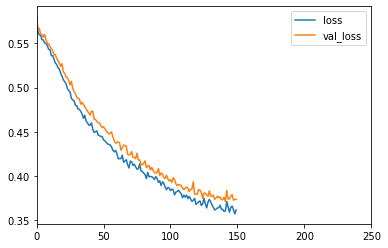

In [856]:
loss_df = pd.DataFrame(model.history.history) 
loss_df.plot()
plt.xlim(0, 250)

In [857]:
predictions = model.predict_classes(X_test)

print(classification_report(y_test,predictions))

print(confusion_matrix(y_test,predictions))

C:\Users\Rodrigo\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning:

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).



              precision    recall  f1-score   support

         0.0       0.85      0.94      0.89      5448
         1.0       0.78      0.56      0.65      2023

    accuracy                           0.84      7471
   macro avg       0.81      0.75      0.77      7471
weighted avg       0.83      0.84      0.83      7471

[[5121  327]
 [ 884 1139]]


In [858]:
predictions_ver = model.predict_classes(df3_final.drop('Label_B',axis=1))

print(classification_report(df3_final['Label_B'],predictions_ver))

print(confusion_matrix(df3_final['Label_B'],predictions_ver))

              precision    recall  f1-score   support

         0.0       0.80      1.00      0.89      3980
         1.0       0.00      0.00      0.00      1020

    accuracy                           0.80      5000
   macro avg       0.40      0.50      0.44      5000
weighted avg       0.63      0.80      0.71      5000

[[3980    0]
 [1020    0]]


C:\Users\Rodrigo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



### Neural Networks 2

In [859]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical


X = df_final.drop('Label_B',axis=1)
y = df_final['Label_B']

#encoder = LabelEncoder()
#encoder.fit(y)
#y = encoder.transform(y)
#y = to_categorical(y)

In [860]:
from sklearn.preprocessing import MinMaxScaler

Scaler = MinMaxScaler()

X_train = Scaler.fit_transform(X_train)
X_test = Scaler.transform(X_test)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential()

model.add(Dense(len(df_final.columns)-1,input_dim = len(df_final.columns)-1,activation='relu'))
model.add(Dense(2*(len(df_final.columns)-1),activation='relu'))
model.add(Dense(2*(len(df_final.columns)-1),activation='relu'))
model.add(Dense(len(df_final.columns)-1,activation='relu'))

# BINARY CLASSIFICATION
#model.add(Dense(3, activation = 'softmax')) # activation='sigmoid'

#model.compile(loss = 'categorical_crossentropy' , optimizer = 'adam' , metrics = ['accuracy'] )

# output layer
model.add(Dense(units=1,activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam')



from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=25, verbose=1, mode='min')


In [861]:
model.fit(x = X_train, y = y_train, validation_data = (X_test,y_test),epochs=350, callbacks=[early_stop])

predictions = model.predict(X_test)

Epoch 1/350
545/545 [==============================] - 2s 2ms/step - loss: 0.5642 - val_loss: 0.5630
Epoch 2/350
545/545 [==============================] - 1s 2ms/step - loss: 0.5479 - val_loss: 0.5529
Epoch 3/350
545/545 [==============================] - 1s 2ms/step - loss: 0.5361 - val_loss: 0.5482
Epoch 4/350
545/545 [==============================] - 1s 2ms/step - loss: 0.5244 - val_loss: 0.5345
Epoch 5/350
545/545 [==============================] - 1s 2ms/step - loss: 0.5107 - val_loss: 0.5314
Epoch 6/350
545/545 [==============================] - 1s 2ms/step - loss: 0.4998 - val_loss: 0.5181
Epoch 7/350
545/545 [==============================] - 1s 2ms/step - loss: 0.4871 - val_loss: 0.5067
Epoch 8/350
545/545 [==============================] - 1s 2ms/step - loss: 0.4752 - val_loss: 0.4995
Epoch 9/350
545/545 [==============================] - 1s 2ms/step - loss: 0.4640 - val_loss: 0.4928
Epoch 10/350
545/545 [==============================] - 1s 2ms/step - loss: 0.4543 - val_lo

In [862]:
predictions = model.predict_classes(X_test)

C:\Users\Rodrigo\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning:

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).



In [863]:
print(classification_report(y_test,predictions))

print(confusion_matrix(y_test,predictions))

              precision    recall  f1-score   support

         0.0       0.90      0.93      0.91      5448
         1.0       0.79      0.72      0.75      2023

    accuracy                           0.87      7471
   macro avg       0.84      0.82      0.83      7471
weighted avg       0.87      0.87      0.87      7471

[[5060  388]
 [ 574 1449]]


In [864]:
predictions_ver = model.predict_classes(df3_final.drop('Label_B',axis=1))

print(classification_report(df3_final['Label_B'],predictions_ver))

print(confusion_matrix(df3_final['Label_B'],predictions_ver))

              precision    recall  f1-score   support

         0.0       0.80      1.00      0.89      3980
         1.0       0.00      0.00      0.00      1020

    accuracy                           0.80      5000
   macro avg       0.40      0.50      0.44      5000
weighted avg       0.63      0.80      0.71      5000

[[3980    0]
 [1020    0]]


C:\Users\Rodrigo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

